In [5]:
import cv2
from ultralytics import YOLO, SAM
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

# Model ve video yolları
yolo_model_path = "best_futbol.pt"
ball_model_path = "futbol_best.pt"
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = "fb2.mp4"
output_video_path = "output_combined_video2.mp4"

# Modelleri yükle
yolo_model = YOLO(yolo_model_path)
ball_model = YOLO(ball_model_path)
sam_model = SAM(sam_model_path)
print(f"YOLO modeli (oyuncular) yüklendi: {yolo_model_path}")
print(f"YOLO modeli (top) yüklendi: {ball_model_path}")
print(f"MobileSAM modeli yüklendi: {sam_model_path}")

# DeepSORT tracker
tracker_players = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, max_cosine_distance=0.3)

# Perspektif dönüşüm matrisi
tl = [1412, 162]
bl = [712, 712]
tr = [882, 102]
br = [-165, 425]
pts_src = np.float32([tl, bl, br, tr])
pts_dst = np.float32([[0, 0], [0, 680], [403, 680], [403, 0]])
matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)

# Renkler
np.random.seed(42)
colors = np.random.randint(0, 255, size=(100, 3), dtype=np.uint8)
ball_color = (0, 255, 255)
possession_color = (0, 0, 255)

# Video bilgilerini al
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"\n📹 Video Bilgileri:")
    print(f"FPS: {fps}")
    print(f"Toplam Frame: {total_frames}")
    print(f"Çözünürlük: {frame_width}x{frame_height}")
    
    # Geçici klasör oluştur
    temp_folder = "temp_frames"
    os.makedirs(temp_folder, exist_ok=True)
    print(f"\n🎬 Video işleme başlıyor...")
    
    frame_count = 0
    
    # Oyuncu izleri için veri yapısı
    player_trails = {}  # {track_id: [(x, y), ...]}
    ball_trail = []
    
    for frame_idx in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        
        # İlerleme göster
        if frame_idx % 10 == 0:
            print(f"Frame {frame_idx+1}/{total_frames} işleniyor...")
        
        original_frame = frame.copy()
        
        # Oyuncular için detection
        player_results = yolo_model(frame, verbose=False)
        ball_results = ball_model(frame, verbose=False)
        
        # Detection listeleri
        player_detections = []
        player_boxes = []
        ball_boxes = []
        player_centers = []
        ball_centers = []
        
        # Oyuncu detections
        if player_results[0].boxes is not None:
            for box in player_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                confidence = float(box.conf[0])
                class_name = yolo_model.names[int(box.cls[0])]
                
                bbox = [x1, y1, x2 - x1, y2 - y1]
                player_detections.append((bbox, confidence, class_name))
                player_boxes.append([x1, y1, x2, y2])
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                player_centers.append((cx, cy))
        
        # Top detections
        ball_position = None
        if ball_results[0].boxes is not None:
            for box in ball_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                ball_boxes.append([x1, y1, x2, y2])
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                ball_centers.append((cx, cy))
                
                if ball_position is None:
                    ball_position = [x1, y1, x2, y2]
        
        # DeepSORT tracking
        player_tracks = tracker_players.update_tracks(player_detections, frame=original_frame)
        
        # Topa en yakın oyuncu
        def calculate_distance(box1, box2):
            center1_x = (box1[0] + box1[2]) / 2
            center1_y = (box1[1] + box1[3]) / 2
            center2_x = (box2[0] + box2[2]) / 2
            center2_y = (box2[1] + box2[3]) / 2
            return np.sqrt((center1_x - center2_x)**2 + (center1_y - center2_y)**2)
        
        closest_player = None
        min_distance = float('inf')
        
        if ball_position is not None:
            for track in player_tracks:
                if track.is_confirmed():
                    ltrb = track.to_ltrb()
                    distance = calculate_distance(ltrb, ball_position)
                    if distance < min_distance and distance < 150:
                        min_distance = distance
                        closest_player = track.track_id
        
        player_with_ball = closest_player
        
        # SAM segmentasyon
        display_frame = original_frame.copy()
        all_boxes = player_boxes + ball_boxes
        
        if len(all_boxes) > 0:
            sam_results = sam_model(original_frame, bboxes=np.array(all_boxes), verbose=False)
            
            if sam_results[0].masks is not None:
                masks = sam_results[0].masks.data.cpu().numpy()
                confirmed_tracks = [t for t in player_tracks if t.is_confirmed()]
                
                for i, mask in enumerate(masks):
                    if i < len(confirmed_tracks):
                        track = confirmed_tracks[i]
                        track_id = track.track_id
                        track_id_int = int(track_id) if isinstance(track_id, str) else track_id
                        
                        if track_id == player_with_ball:
                            color = possession_color
                        else:
                            color = colors[track_id_int % len(colors)]
                        
                        mask = mask.astype(np.uint8) * 255
                        mask_resized = cv2.resize(mask, (frame_width, frame_height))
                        colored_mask = np.zeros_like(display_frame)
                        colored_mask[mask_resized > 0] = color
                        display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
                    
                    elif i >= len(confirmed_tracks):
                        mask = mask.astype(np.uint8) * 255
                        mask_resized = cv2.resize(mask, (frame_width, frame_height))
                        colored_mask = np.zeros_like(display_frame)
                        colored_mask[mask_resized > 0] = ball_color
                        display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
        
        # Topa sahip oyuncu için box çiz
        for track in player_tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = map(int, ltrb)
            
            if track_id == player_with_ball:
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), possession_color, 3)
                label = 'TOPA SAHİP OYUNCU'
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                cv2.rectangle(display_frame, (x1, y1 - text_height - 15), (x1 + text_width + 10, y1), possession_color, -1)
                cv2.putText(display_frame, label, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        # Bilgi metni
        player_count = len([t for t in player_tracks if t.is_confirmed()])
        ball_count = len(ball_boxes)
        info_text = f'Players: {player_count} | Ball: {ball_count}'
        cv2.putText(display_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        if player_with_ball is not None:
            possession_text = f'Topa Sahip Oyuncu ID: {player_with_ball}'
            cv2.putText(display_frame, possession_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Perspektif dönüşümü ve iz kaydetme
        transformed_players = []
        for idx, (px, py) in enumerate(player_centers):
            point = np.array([[[px, py]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            tx, ty = transformed[0][0][0], transformed[0][0][1]
            transformed_players.append((tx, ty))
            
            # İz kaydetme
            if idx < len([t for t in player_tracks if t.is_confirmed()]):
                confirmed = [t for t in player_tracks if t.is_confirmed()]
                if idx < len(confirmed):
                    track_id = confirmed[idx].track_id
                    if track_id not in player_trails:
                        player_trails[track_id] = []
                    player_trails[track_id].append((tx, ty))
                    # Son 30 frame'i sakla
                    if len(player_trails[track_id]) > 30:
                        player_trails[track_id] = player_trails[track_id][-30:]
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            tbx, tby = transformed[0][0][0], transformed[0][0][1]
            transformed_balls.append((tbx, tby))
            ball_trail.append((tbx, tby))
            if len(ball_trail) > 50:
                ball_trail = ball_trail[-50:]
        
        # Görselleştirme
        fig = plt.figure(figsize=(20, 9))
        gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Segmentasyon + Takip', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı
        ax2.set_xlim(-10, 413)
        ax2.set_ylim(690, -10)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Saha (Kale Sağda)', fontsize=14, fontweight='bold')
        
        # Saha çizimi
        saha = patches.Rectangle((0, 0), 403, 680, linewidth=3, edgecolor='white', facecolor='green', alpha=0.7)
        ax2.add_patch(saha)
        
        ax2.plot([0, 403], [0, 0], 'white', linewidth=3)
        ax2.plot([0, 403], [680, 680], 'white', linewidth=3)
        ax2.plot([0, 0], [0, 680], 'white', linewidth=3)
        ax2.plot([403, 403], [0, 680], 'white', linewidth=3)
        
        # Penalty area
        penalty_depth = 165
        penalty_width = 403
        penalty_x = 403 - penalty_depth
        penalty_y = (680 - penalty_width) / 2
        penalty_area = patches.Rectangle((penalty_x, penalty_y), penalty_depth, penalty_width,
                                        linewidth=2, edgecolor='white', facecolor='none')
        ax2.add_patch(penalty_area)
        
        # Goal area
        goal_depth = 55
        goal_width = 187
        goal_x = 403 - goal_depth
        goal_y = (680 - goal_width) / 2
        goal_area = patches.Rectangle((goal_x, goal_y), goal_depth, goal_width,
                                      linewidth=2, edgecolor='white', facecolor='none')
        ax2.add_patch(goal_area)
        
        # Penalty noktası
        penalty_spot_x = 403 - 110
        penalty_spot_y = 340
        ax2.plot(penalty_spot_x, penalty_spot_y, 'wo', markersize=8)
        
        # Kale
        kale_width = 73
        kale_y = (680 - kale_width) / 2
        ax2.plot([403, 403], [kale_y, kale_y + kale_width], 'white', linewidth=5)
        
        # Oyuncu izleri
        for track_id, trail in player_trails.items():
            if len(trail) > 1:
                trail_array = np.array(trail)
                ax2.plot(trail_array[:, 0], trail_array[:, 1], 
                        alpha=0.3, linewidth=2, color='cyan')
        
        # Top izi
        if len(ball_trail) > 1:
            ball_trail_array = np.array(ball_trail)
            ax2.plot(ball_trail_array[:, 0], ball_trail_array[:, 1],
                    alpha=0.5, linewidth=2, color='yellow', linestyle='--')
        
        # Oyuncular
        for tx, ty in transformed_players:
            if 0 <= tx <= 403 and 0 <= ty <= 680:
                circle = patches.Circle((tx, ty), 8, color='red', ec='white', linewidth=2, zorder=10)
                ax2.add_patch(circle)
        
        # Top
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 403 and 0 <= tby <= 680:
                circle = patches.Circle((tbx, tby), 6, color='yellow', ec='black', linewidth=2, zorder=11)
                ax2.add_patch(circle)
        
        ax2.grid(True, alpha=0.3, color='white', linestyle='--')
        ax2.set_facecolor('darkgreen')
        
        # Etiketler
        ax2.text(201, -5, '40.3m', fontsize=10, color='white', ha='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        ax2.text(-5, 340, '68m', fontsize=10, color='white', rotation=90, va='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        ax2.text(408, 340, 'KALE', fontsize=10, color='white', rotation=90, va='center', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
        
        info_text_bird = f'Tespit: {len(transformed_players)} Oyuncu\n{len(transformed_balls)} Top\nFrame: {frame_idx+1}/{total_frames}'
        ax2.text(10, 20, info_text_bird, fontsize=12, color='white',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        
        # Frame'i kaydet
        temp_file = os.path.join(temp_folder, f"frame_{frame_idx:05d}.png")
        plt.savefig(temp_file, dpi=100, bbox_inches='tight')
        plt.close()
        
        frame_count += 1
    
    cap.release()
    
    print(f"\n✅ {frame_count} frame işlendi!")
    print(f"\n🎬 Video oluşturuluyor...")
    
    # Frame'leri videoya dönüştür
    first_frame = cv2.imread(os.path.join(temp_folder, "frame_00000.png"))
    output_height, output_width = first_frame.shape[:2]
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_width, output_height))
    
    for i in range(frame_count):
        if i % 20 == 0:
            print(f"Video yazılıyor: {i+1}/{frame_count}")
        frame_file = os.path.join(temp_folder, f"frame_{i:05d}.png")
        img = cv2.imread(frame_file)
        out.write(img)
    
    out.release()
    
    # Geçici dosyaları temizle
    print(f"\n🧹 Geçici dosyalar temizleniyor...")
    for i in range(frame_count):
        frame_file = os.path.join(temp_folder, f"frame_{i:05d}.png")
        if os.path.exists(frame_file):
            os.remove(frame_file)
    os.rmdir(temp_folder)
    
    print(f"\n✅ Video kaydedildi: {output_video_path}")
    print(f"📊 Saha boyutları: 40.3m x 68m")
    print(f"📊 Penalty area: 16.5m (boy) x 40.3m (en)")
    print(f"📊 Goal area: 5.5m (boy) x 18.7m (en)")
    
    # Videoyu göster
    from IPython.display import Video, display
    display(Video(output_video_path, width=1200))


YOLO modeli (oyuncular) yüklendi: best_futbol.pt
YOLO modeli (top) yüklendi: futbol_best.pt
MobileSAM modeli yüklendi: C:\Users\User\Desktop\MobileSAM\mobile_sam.pt

📹 Video Bilgileri:
FPS: 30
Toplam Frame: 394
Çözünürlük: 1280x720

🎬 Video işleme başlıyor...
Frame 1/394 işleniyor...

📹 Video Bilgileri:
FPS: 30
Toplam Frame: 394
Çözünürlük: 1280x720

🎬 Video işleme başlıyor...
Frame 1/394 işleniyor...
Frame 11/394 işleniyor...
Frame 11/394 işleniyor...


Exception ignored in: <function tqdm.__del__ at 0x000001CBA787B920>
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Frame 21/394 işleniyor...
Frame 31/394 işleniyor...
Frame 31/394 işleniyor...
Frame 41/394 işleniyor...
Frame 41/394 işleniyor...
Frame 51/394 işleniyor...
Frame 51/394 işleniyor...
Frame 61/394 işleniyor...
Frame 61/394 işleniyor...
Frame 71/394 işleniyor...
Frame 71/394 işleniyor...
Frame 81/394 işleniyor...
Frame 81/394 işleniyor...
Frame 91/394 işleniyor...
Frame 91/394 işleniyor...
Frame 101/394 işleniyor...
Frame 101/394 işleniyor...
Frame 111/394 işleniyor...
Frame 111/394 işleniyor...
Frame 121/394 işleniyor...
Frame 121/394 işleniyor...
Frame 131/394 işleniyor...
Frame 131/394 işleniyor...
Frame 141/394 işleniyor...
Frame 141/394 işleniyor...
Frame 151/394 işleniyor...
Frame 151/394 işleniyor...
Frame 161/394 işleniyor...
Frame 161/394 işleniyor...
Frame 171/394 işleniyor...
Frame 171/394 işleniyor...
Frame 181/394 işleniyor...
Frame 181/394 işleniyor...
Frame 191/394 işleniyor...
Frame 191/394 işleniyor...
Frame 201/394 işleniyor...
Frame 201/394 işleniyor...
Frame 211/394 iş

In [27]:
import cv2
from ultralytics import YOLO, SAM
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Model ve video yolları
yolo_model_path = "best_futbol.pt"  # Oyuncular için
ball_model_path = "futbol_best.pt"  # Top için
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = "fb2.mp4"

# Modelleri yükle
yolo_model = YOLO(yolo_model_path)
ball_model = YOLO(ball_model_path)
sam_model = SAM(sam_model_path)
print(f"YOLO modeli (oyuncular) yüklendi: {yolo_model_path}")
print(f"YOLO modeli (top) yüklendi: {ball_model_path}")
print(f"MobileSAM modeli yüklendi: {sam_model_path}")

# DeepSORT tracker
tracker_players = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, max_cosine_distance=0.3)

# Videoyu aç ve ilk frame'i al
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    ret, frame = cap.read()
    
    if ret:
        frame_height, frame_width = frame.shape[:2]
        original_frame = frame.copy()
        
        # Perspektif dönüşüm noktaları
        tl = [1412, 162]
        bl = [712, 712]
        tr = [882, 102]
        br = [-165, 425]
        
        pts_src = np.float32([tl, bl, br, tr])
        pts_dst = np.float32([[0, 0], [0, 680], [350, 680], [350, 0]])
        matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
        
        # Oyuncular için detection
        player_results = yolo_model(frame, verbose=False)
        ball_results = ball_model(frame, verbose=False)
        
        # Renkler
        np.random.seed(42)
        colors = np.random.randint(0, 255, size=(100, 3), dtype=np.uint8)
        ball_color = (0, 255, 255)
        possession_color = (0, 0, 255)
        
        # Detection listeleri
        player_detections = []
        player_boxes = []
        ball_boxes = []
        player_centers = []
        ball_centers = []
        
        # Oyuncu detections
        if player_results[0].boxes is not None:
            for box in player_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                confidence = float(box.conf[0])
                class_name = yolo_model.names[int(box.cls[0])]
                
                bbox = [x1, y1, x2 - x1, y2 - y1]
                player_detections.append((bbox, confidence, class_name))
                player_boxes.append([x1, y1, x2, y2])
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                player_centers.append((cx, cy))
        
        # Top detections
        ball_position = None
        if ball_results[0].boxes is not None:
            for box in ball_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                ball_boxes.append([x1, y1, x2, y2])
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                ball_centers.append((cx, cy))
                
                if ball_position is None:
                    ball_position = [x1, y1, x2, y2]
        
        # DeepSORT tracking
        player_tracks = tracker_players.update_tracks(player_detections, frame=original_frame)
        
        # Topa en yakın oyuncu
        def calculate_distance(box1, box2):
            center1_x = (box1[0] + box1[2]) / 2
            center1_y = (box1[1] + box1[3]) / 2
            center2_x = (box2[0] + box2[2]) / 2
            center2_y = (box2[1] + box2[3]) / 2
            return np.sqrt((center1_x - center2_x)**2 + (center1_y - center2_y)**2)
        
        closest_player = None
        min_distance = float('inf')
        
        if ball_position is not None:
            for track in player_tracks:
                if track.is_confirmed():
                    ltrb = track.to_ltrb()
                    distance = calculate_distance(ltrb, ball_position)
                    if distance < min_distance and distance < 150:
                        min_distance = distance
                        closest_player = track.track_id
        
        player_with_ball = closest_player
        
        # SAM segmentasyon
        display_frame = original_frame.copy()
        all_boxes = player_boxes + ball_boxes
        
        if len(all_boxes) > 0:
            sam_results = sam_model(original_frame, bboxes=np.array(all_boxes), verbose=False)
            
            if sam_results[0].masks is not None:
                masks = sam_results[0].masks.data.cpu().numpy()
                confirmed_tracks = [t for t in player_tracks if t.is_confirmed()]
                
                for i, mask in enumerate(masks):
                    if i < len(confirmed_tracks):
                        track = confirmed_tracks[i]
                        track_id = track.track_id
                        track_id_int = int(track_id) if isinstance(track_id, str) else track_id
                        
                        if track_id == player_with_ball:
                            color = possession_color
                        else:
                            color = colors[track_id_int % len(colors)]
                        
                        mask = mask.astype(np.uint8) * 255
                        mask_resized = cv2.resize(mask, (frame_width, frame_height))
                        colored_mask = np.zeros_like(display_frame)
                        colored_mask[mask_resized > 0] = color
                        display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
                    
                    elif i >= len(confirmed_tracks):
                        mask = mask.astype(np.uint8) * 255
                        mask_resized = cv2.resize(mask, (frame_width, frame_height))
                        colored_mask = np.zeros_like(display_frame)
                        colored_mask[mask_resized > 0] = ball_color
                        display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
        
        # Topa sahip oyuncu için box çiz
        for track in player_tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = map(int, ltrb)
            
            if track_id == player_with_ball:
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), possession_color, 3)
                label = 'TOPA SAHİP OYUNCU'
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                cv2.rectangle(display_frame, (x1, y1 - text_height - 15), (x1 + text_width + 10, y1), possession_color, -1)
                cv2.putText(display_frame, label, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        # Bilgi metni
        player_count = len([t for t in player_tracks if t.is_confirmed()])
        ball_count = len(ball_boxes)
        info_text = f'Players: {player_count} | Ball: {ball_count}'
        cv2.putText(display_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        if player_with_ball is not None:
            possession_text = f'Topa Sahip Oyuncu ID: {player_with_ball}'
            cv2.putText(display_frame, possession_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Perspektif dönüşümü
        transformed_players = []
        for px, py in player_centers:
            point = np.array([[[px, py]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_players.append((transformed[0][0][0], transformed[0][0][1]))
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Görselleştirme - Yan yana
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Segmentasyon + Takip', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı
        ax2.set_xlim(-10, 360)
        ax2.set_ylim(690, -10)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Saha Görünümü', fontsize=14, fontweight='bold')
        
        # Saha çizimi
        saha = patches.Rectangle((0, 0), 350, 680, linewidth=3, edgecolor='white', facecolor='green', alpha=0.7)
        ax2.add_patch(saha)
        
        ax2.plot([175, 175], [0, 680], 'white', linewidth=2)
        ax2.plot([0, 0], [0, 680], 'white', linewidth=3)
        ax2.plot([350, 350], [0, 680], 'white', linewidth=3)
        ax2.plot([0, 350], [0, 0], 'white', linewidth=3)
        ax2.plot([0, 350], [680, 680], 'white', linewidth=3)
        
        kale_onu_width = 165
        kale_onu_height = 403
        kale_onu_x = (350 - kale_onu_width) / 2
        kale_onu_y = 680 - kale_onu_height
        kale_onu = patches.Rectangle((kale_onu_x, kale_onu_y), kale_onu_width, kale_onu_height,
                                      linewidth=2, edgecolor='white', facecolor='none')
        ax2.add_patch(kale_onu)
        
        kale_width = 73
        kale_x = (350 - kale_width) / 2
        ax2.plot([kale_x, kale_x + kale_width], [680, 680], 'white', linewidth=4)
        
        # Oyuncular
        for tx, ty in transformed_players:
            if 0 <= tx <= 350 and 0 <= ty <= 680:
                circle = patches.Circle((tx, ty), 8, color='red', ec='white', linewidth=2, zorder=10)
                ax2.add_patch(circle)
        
        # Top
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 350 and 0 <= tby <= 680:
                circle = patches.Circle((tbx, tby), 6, color='yellow', ec='black', linewidth=2, zorder=11)
                ax2.add_patch(circle)
        
        ax2.grid(True, alpha=0.3, color='white', linestyle='--')
        ax2.set_facecolor('darkgreen')
        
        info_text_bird = f'Tespit: {len(transformed_players)} Oyuncu\n{len(transformed_balls)} Top'
        ax2.text(10, 30, info_text_bird, fontsize=12, color='white',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✅ Tek frame görselleştirme tamamlandı!")
        print(f"Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Saha")
    
    cap.release()


YOLO modeli (oyuncular) yüklendi: best_futbol.pt
YOLO modeli (top) yüklendi: futbol_best.pt
MobileSAM modeli yüklendi: C:\Users\User\Desktop\MobileSAM\mobile_sam.pt

✅ Tek frame görselleştirme tamamlandı!
Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Saha

✅ Tek frame görselleştirme tamamlandı!
Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Saha


C:\Users\User\AppData\Local\Temp\ipykernel_12428\429931954.py:249: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [1]:
# Kaydedilen modeli test etme
# Testing the saved model with real.jpeg

# Gerekli kütüphaneleri yükleme
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

print("Kütüphaneler yüklendi!")
print("Libraries loaded successfully!")

Kütüphaneler yüklendi!
Libraries loaded successfully!


In [3]:
# Kaydedilen modeli yükleme
# Loading the saved model
model_path = "best_futbol.pt"
model = YOLO(model_path)

print(f"Model yüklendi: {model_path}")
print(f"Model loaded: {model_path}")

# Model bilgilerini gösterme
print("\nModel bilgileri:")
print("Model information:")
print(f"Model tipi: {type(model)}")
print(f"Model type: {type(model)}")

Model yüklendi: best_futbol.pt
Model loaded: best_futbol.pt

Model bilgileri:
Model information:
Model tipi: <class 'ultralytics.models.yolo.model.YOLO'>
Model type: <class 'ultralytics.models.yolo.model.YOLO'>


In [9]:
# Test görselini yükleme ve kontrol etme
# Loading and checking the test image
image_path = "fb1.PNG"

# Görsel dosyasının var olup olmadığını kontrol etme
if os.path.exists(image_path):
    print(f"✓ Test görseli bulundu: {image_path}")
    print(f"✓ Test image found: {image_path}")
    
    # Görseli OpenCV ile yükleme
    image = cv2.imread(image_path)
    if image is not None:
        print(f"Görsel boyutu: {image.shape}")
        print(f"Image dimensions: {image.shape}")
    else:
        print("❌ Görsel yüklenemedi!")
        print("❌ Failed to load image!")
else:
    print(f"❌ Test görseli bulunamadı: {image_path}")
    print(f"❌ Test image not found: {image_path}")

✓ Test görseli bulundu: fb1.PNG
✓ Test image found: fb1.PNG
Görsel boyutu: (648, 1263, 3)
Image dimensions: (648, 1263, 3)


In [10]:
# Modeli test görselinde çalıştırma
# Running the model on the test image
print("Model tahminlerini çalıştırıyor...")
print("Running model predictions...")

# YOLO modelini görsel üzerinde çalıştırma
results = model(image_path)

print("✓ Tahminler tamamlandı!")
print("✓ Predictions completed!")
print(f"Tespit edilen nesne sayısı: {len(results[0].boxes) if results[0].boxes is not None else 0}")
print(f"Number of detected objects: {len(results[0].boxes) if results[0].boxes is not None else 0}")

Model tahminlerini çalıştırıyor...
Running model predictions...

image 1/1 c:\Users\User\Desktop\futbol\fb1.PNG: 352x640 17 players, 99.5ms
Speed: 2.7ms preprocess, 99.5ms inference, 5.6ms postprocess per image at shape (1, 3, 352, 640)
✓ Tahminler tamamlandı!
✓ Predictions completed!
Tespit edilen nesne sayısı: 17
Number of detected objects: 17
image 1/1 c:\Users\User\Desktop\futbol\fb1.PNG: 352x640 17 players, 99.5ms
Speed: 2.7ms preprocess, 99.5ms inference, 5.6ms postprocess per image at shape (1, 3, 352, 640)
✓ Tahminler tamamlandı!
✓ Predictions completed!
Tespit edilen nesne sayısı: 17
Number of detected objects: 17


In [11]:
# Tespit sonuçlarını detaylı olarak gösterme
# Displaying detection results in detail
if results[0].boxes is not None and len(results[0].boxes) > 0:
    print("\n🔍 Detaylı tespit sonuçları:")
    print("🔍 Detailed detection results:")
    
    for i, box in enumerate(results[0].boxes):
        # Koordinatlar
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        confidence = float(box.conf[0])
        class_id = int(box.cls[0])
        class_name = model.names[class_id]
        
        print(f"\nNesne {i+1} / Object {i+1}:")
        print(f"  Sınıf / Class: {class_name}")
        print(f"  Güven oranı / Confidence: {confidence:.2f}")
        print(f"  Koordinatlar / Coordinates: ({x1:.0f}, {y1:.0f}) - ({x2:.0f}, {y2:.0f})")
        print(f"  Genişlik x Yükseklik / Width x Height: {x2-x1:.0f} x {y2-y1:.0f}")
else:
    print("\n❌ Hiçbir nesne tespit edilemedi!")
    print("❌ No objects detected!")


🔍 Detaylı tespit sonuçları:
🔍 Detailed detection results:

Nesne 1 / Object 1:
  Sınıf / Class: player
  Güven oranı / Confidence: 0.79
  Koordinatlar / Coordinates: (222, 464) - (280, 549)
  Genişlik x Yükseklik / Width x Height: 58 x 86

Nesne 2 / Object 2:
  Sınıf / Class: player
  Güven oranı / Confidence: 0.76
  Koordinatlar / Coordinates: (431, 429) - (471, 517)
  Genişlik x Yükseklik / Width x Height: 40 x 88

Nesne 3 / Object 3:
  Sınıf / Class: player
  Güven oranı / Confidence: 0.76
  Koordinatlar / Coordinates: (583, 285) - (617, 362)
  Genişlik x Yükseklik / Width x Height: 34 x 77

Nesne 4 / Object 4:
  Sınıf / Class: player
  Güven oranı / Confidence: 0.73
  Koordinatlar / Coordinates: (935, 288) - (969, 363)
  Genişlik x Yükseklik / Width x Height: 33 x 74

Nesne 5 / Object 5:
  Sınıf / Class: player
  Güven oranı / Confidence: 0.73
  Koordinatlar / Coordinates: (1232, 121) - (1261, 184)
  Genişlik x Yükseklik / Width x Height: 29 x 63

Nesne 6 / Object 6:
  Sınıf / Cla

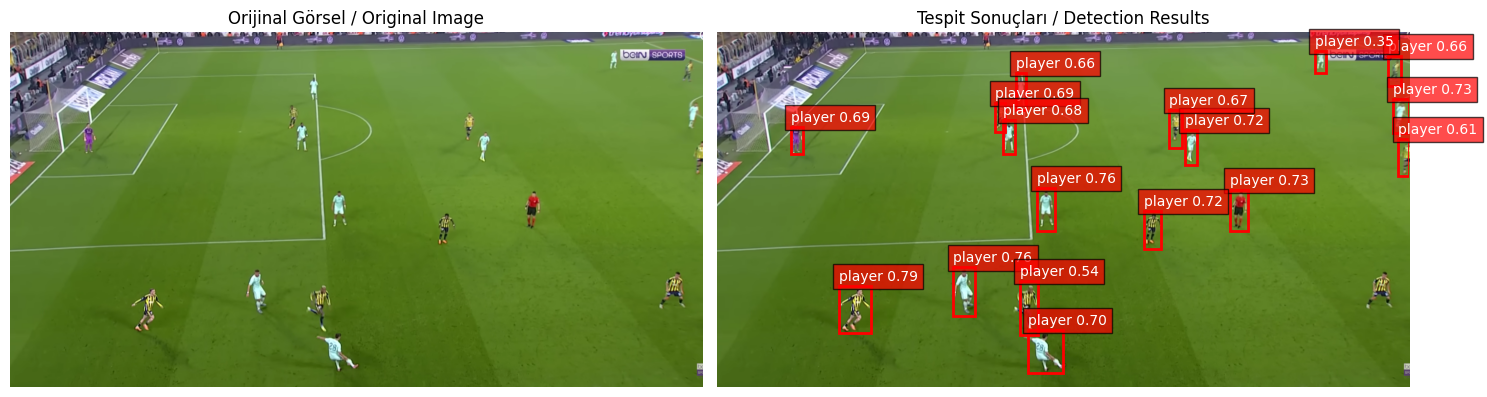


✅ Test tamamlandı! Model başarıyla fb1.PNG dosyasında test edildi.
✅ Testing completed! Model successfully tested on fb1.PNG.


In [12]:
# Sonuçları görselleştirme
# Visualizing the results
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Görseli PIL ile yükleme
pil_image = Image.open(image_path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Matplotlib figure oluşturma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Orijinal görsel
ax1.imshow(rgb_image)
ax1.set_title('Orijinal Görsel / Original Image')
ax1.axis('off')

# Tespit edilmiş nesnelerle görsel
ax2.imshow(rgb_image)
ax2.set_title('Tespit Sonuçları / Detection Results')
ax2.axis('off')

# Tespit edilmiş nesneleri çizme
if results[0].boxes is not None and len(results[0].boxes) > 0:
    for i, box in enumerate(results[0].boxes):
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        confidence = float(box.conf[0])
        class_id = int(box.cls[0])
        class_name = model.names[class_id]
        
        # Bounding box çizme
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                               linewidth=2, edgecolor='red', facecolor='none')
        ax2.add_patch(rect)
        
        # Label ekleme
        ax2.text(x1, y1-10, f'{class_name} {confidence:.2f}', 
                bbox=dict(facecolor='red', alpha=0.7), 
                fontsize=10, color='white')

plt.tight_layout()
plt.show()

print(f"\n✅ Test tamamlandı! Model başarıyla {image_path} dosyasında test edildi.")
print(f"✅ Testing completed! Model successfully tested on {image_path}.")

In [21]:
# Video üzerinde model testi - fb2.mp4
# Testing model on video - fb2.mp4

import cv2
from ultralytics import YOLO

# Model ve video yolları
model_path = "best_futbol.pt"
video_path = "fb2.mp4"
output_path = "output2_fb2.mp4"

# Modeli yükle
model = YOLO(model_path)
print(f"Model yüklendi: {model_path}")

# Videoyu aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Video özelliklerini al
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"✓ Video açıldı: {video_path}")
    print(f"Video özellikleri: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frame")
    
    # Video yazıcıyı oluştur
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    frame_count = 0
    
    print("\nVideo işleniyor...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # Her frame'i modelle işle
        results = model(frame, verbose=False)
        
        # Sonuçları frame üzerine çiz
        annotated_frame = results[0].plot()
        
        # İşlenmiş frame'i kaydet
        out.write(annotated_frame)
        
        # İlerleme göster (her 30 frame'de bir)
        if frame_count % 30 == 0:
            print(f"İşlenen frame: {frame_count}/{total_frames} ({100*frame_count/total_frames:.1f}%)")
    
    # Kaynakları temizle
    cap.release()
    out.release()
    
    print(f"\n✅ Video işleme tamamlandı!")
    print(f"✅ Çıktı kaydedildi: {output_path}")
    print(f"Toplam işlenen frame: {frame_count}")


Model yüklendi: best_futbol.pt
✓ Video açıldı: fb2.mp4
Video özellikleri: 1280x720, 30 FPS, 394 frame

Video işleniyor...
İşlenen frame: 30/394 (7.6%)
İşlenen frame: 30/394 (7.6%)
İşlenen frame: 60/394 (15.2%)
İşlenen frame: 60/394 (15.2%)
İşlenen frame: 90/394 (22.8%)
İşlenen frame: 90/394 (22.8%)
İşlenen frame: 120/394 (30.5%)
İşlenen frame: 120/394 (30.5%)
İşlenen frame: 150/394 (38.1%)
İşlenen frame: 150/394 (38.1%)
İşlenen frame: 180/394 (45.7%)
İşlenen frame: 180/394 (45.7%)
İşlenen frame: 210/394 (53.3%)
İşlenen frame: 210/394 (53.3%)
İşlenen frame: 240/394 (60.9%)
İşlenen frame: 240/394 (60.9%)
İşlenen frame: 270/394 (68.5%)
İşlenen frame: 270/394 (68.5%)
İşlenen frame: 300/394 (76.1%)
İşlenen frame: 300/394 (76.1%)
İşlenen frame: 330/394 (83.8%)
İşlenen frame: 330/394 (83.8%)
İşlenen frame: 360/394 (91.4%)
İşlenen frame: 360/394 (91.4%)
İşlenen frame: 390/394 (99.0%)
İşlenen frame: 390/394 (99.0%)

✅ Video işleme tamamlandı!
✅ Çıktı kaydedildi: output2_fb2.mp4
Toplam işlenen f

In [25]:
import cv2
from ultralytics import YOLO
import numpy as np

# Model ve video yolları
model_path1 = "best_futbol.pt"
model_path2 = "futbol_best.pt"
video_path = "fb2.mp4"
output_path = "output_compare.mp4"   # Çıktı video

# Her iki modeli yükle
model1 = YOLO(model_path1)
model2 = YOLO(model_path2)
print(f"Model 1 yüklendi: {model_path1}")
print(f"Model 2 yüklendi: {model_path2}")

# Videoyu aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
    exit()

# Video bilgileri
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"✓ Video açıldı: {video_path}")
print(f"Video özellikleri: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frame")
print("\nVideo işleniyor...")

# VideoWriter: mp4 codec → mp4v
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Her iki modeli çalıştır
    results1 = model1(frame, verbose=False)
    results2 = model2(frame, verbose=False)

    display_frame = frame.copy()

    # Model 1 → KIRMIZI
    if results1[0].boxes is not None and len(results1[0].boxes) > 0:
        for box in results1[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            confidence = float(box.conf[0])
            class_name = model1.names[int(box.cls[0])]

            cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
            label = f'{class_name} {confidence:.2f}'
            cv2.putText(display_frame, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Model 2 → MAVİ
    if results2[0].boxes is not None and len(results2[0].boxes) > 0:
        for box in results2[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            confidence = float(box.conf[0])
            class_name = model2.names[int(box.cls[0])]

            cv2.rectangle(display_frame, (x1, y1), (x2, y2), (255, 0, 0), 3)
            label = f'{class_name} {confidence:.2f}'
            cv2.putText(display_frame, label, (x1, y2 + 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Çıktı videosuna yaz
    out.write(display_frame)

    # Progress
    if frame_count % 50 == 0:
        print(f"İşlenen frame: {frame_count}/{total_frames} "
              f"(%{100 * frame_count / total_frames:.1f})")

# Kaynakları serbest bırak
cap.release()
out.release()

print("\n✅ Video işleme tamamlandı!")
print(f"📁 Kaydedildi: {output_path}")
print(f"Toplam işlenen frame: {frame_count}")


Model 1 yüklendi: best_futbol.pt
Model 2 yüklendi: futbol_best.pt
✓ Video açıldı: fb2.mp4
Video özellikleri: 1280x720, 30.0 FPS, 394 frame

Video işleniyor...
İşlenen frame: 50/394 (%12.7)
İşlenen frame: 100/394 (%25.4)
İşlenen frame: 150/394 (%38.1)
İşlenen frame: 200/394 (%50.8)
İşlenen frame: 250/394 (%63.5)
İşlenen frame: 300/394 (%76.1)
İşlenen frame: 350/394 (%88.8)

✅ Video işleme tamamlandı!
📁 Kaydedildi: output_compare.mp4
Toplam işlenen frame: 394


In [26]:
# DeepSORT kütüphanesini kurulum
# Installing DeepSORT library
!pip install deep-sort-realtime

   ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.4 MB 1.6 MB/s eta 0:00:05
   ---- ----------------------------------- 1.0/8.4 MB 1.8 MB/s eta 0:00:05
   ---- ----------------------------------- 1.0/8.4 MB 1.8 MB/s eta 0:00:05
   ------- -------------------------------- 1.6/8.4 MB 1.6 MB/s eta 0:00:05
   --------- ------------------------------ 2.1/8.4 MB 1.8 MB/s eta 0:00:04
   ------------ --------------------------- 2.6/8.4 MB 2.1 MB/s eta 0:00:03
   ---------------- ----------------------- 3.4/8.4 MB 2.3 MB/s eta 0:00:03
   ------------------- -------------------- 4.2/8.4 MB 2.5 MB/s eta 0:00:02
   ---------------------- ----------------- 4.7/8.4 MB 2.4 MB/s eta 0:00:02
   --------------------------- ------------ 5.8/8.4 MB 2.7 MB/s eta 0:00:01
   ---------------------------------- ----- 7.3/8.4 MB 3.1 MB/s eta 0:00:01
   -----------------------

In [28]:
import cv2
from ultralytics import YOLO
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort

# Model ve video yolları
model_path1 = "best_futbol.pt"
model_path2 = "futbol_best.pt"
video_path = "fb2.mp4"
output_path = "output_tracked.mp4"

# Modelleri yükle
model1 = YOLO(model_path1)
model2 = YOLO(model_path2)
print(f"Model 1 yüklendi: {model_path1}")
print(f"Model 2 yüklendi: {model_path2}")

# DeepSORT tracker'ı başlat
tracker = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, max_cosine_distance=0.3)
print("DeepSORT tracker başlatıldı")

# Videoyu aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
    exit()

# Video bilgileri
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"✓ Video açıldı: {video_path}")
print(f"Video özellikleri: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frame")
print("\nVideo işleniyor...")

# VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0

# Renk paleti (her ID için farklı renk)
np.random.seed(42)
colors = np.random.randint(0, 255, size=(100, 3), dtype=np.uint8)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # İki modelden tespit al (birinci model kullanılacak)
    results1 = model1(frame, verbose=False)
    
    # DeepSORT için detection listesi hazırla
    detections = []
    
    if results1[0].boxes is not None and len(results1[0].boxes) > 0:
        for box in results1[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            confidence = float(box.conf[0])
            class_id = int(box.cls[0])
            class_name = model1.names[class_id]
            
            # DeepSORT formatı: ([left, top, width, height], confidence, class_name)
            bbox = [x1, y1, x2 - x1, y2 - y1]
            detections.append((bbox, confidence, class_name))
    
    # DeepSORT ile takip et
    tracks = tracker.update_tracks(detections, frame=frame)
    
    display_frame = frame.copy()
    
    # Takip edilen nesneleri çiz
    for track in tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        
        # Her ID için benzersiz renk (track_id'yi int'e çevir)
        track_id_int = int(track_id) if isinstance(track_id, str) else track_id
        color = tuple(map(int, colors[track_id_int % len(colors)]))
        
        # Bounding box çiz
        cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 3)
        
        # Sınıf adı ve ID
        class_name = track.get_det_class() if track.get_det_class() else "Unknown"
        label = f'ID:{track_id} {class_name}'
        
        # Label arka planı
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(display_frame, (x1, y1 - text_height - 10), (x1 + text_width, y1), color, -1)
        cv2.putText(display_frame, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Merkez noktası çiz (takip için)
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        cv2.circle(display_frame, (center_x, center_y), 5, color, -1)
    
    # Frame bilgisi ekle
    info_text = f'Frame: {frame_count}/{total_frames} | Tracked Objects: {len([t for t in tracks if t.is_confirmed()])}'
    cv2.putText(display_frame, info_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Çıktı videosuna yaz
    out.write(display_frame)

    # Progress
    if frame_count % 50 == 0:
        print(f"İşlenen frame: {frame_count}/{total_frames} "
              f"(%{100 * frame_count / total_frames:.1f}) - "
              f"Takip edilen: {len([t for t in tracks if t.is_confirmed()])}")

# Kaynakları serbest bırak
cap.release()
out.release()

print("\n✅ Video işleme tamamlandı!")
print(f"📁 Kaydedildi: {output_path}")
print(f"Toplam işlenen frame: {frame_count}")
print(f"✓ DeepSORT ile takip uygulandı - Her nesne benzersiz ID ile işaretlendi")

Model 1 yüklendi: best_futbol.pt
Model 2 yüklendi: futbol_best.pt
DeepSORT tracker başlatıldı
✓ Video açıldı: fb2.mp4
Video özellikleri: 1280x720, 30.0 FPS, 394 frame

Video işleniyor...
İşlenen frame: 50/394 (%12.7) - Takip edilen: 16
İşlenen frame: 50/394 (%12.7) - Takip edilen: 16
İşlenen frame: 100/394 (%25.4) - Takip edilen: 18
İşlenen frame: 100/394 (%25.4) - Takip edilen: 18
İşlenen frame: 150/394 (%38.1) - Takip edilen: 18
İşlenen frame: 150/394 (%38.1) - Takip edilen: 18
İşlenen frame: 200/394 (%50.8) - Takip edilen: 18
İşlenen frame: 200/394 (%50.8) - Takip edilen: 18
İşlenen frame: 250/394 (%63.5) - Takip edilen: 19
İşlenen frame: 250/394 (%63.5) - Takip edilen: 19
İşlenen frame: 300/394 (%76.1) - Takip edilen: 19
İşlenen frame: 300/394 (%76.1) - Takip edilen: 19
İşlenen frame: 350/394 (%88.8) - Takip edilen: 20
İşlenen frame: 350/394 (%88.8) - Takip edilen: 20

✅ Video işleme tamamlandı!
📁 Kaydedildi: output_tracked.mp4
Toplam işlenen frame: 394
✓ DeepSORT ile takip uygulan

In [30]:
import cv2
from ultralytics import YOLO, SAM
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort

# Model ve video yolları
yolo_model_path = "best_futbol.pt"
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = "fb2.mp4"
output_path = "output_tracked_segmented.mp4"

# Modelleri yükle
yolo_model = YOLO(yolo_model_path)
sam_model = SAM(sam_model_path)
print(f"YOLO modeli yüklendi: {yolo_model_path}")
print(f"MobileSAM modeli yüklendi: {sam_model_path}")

# DeepSORT tracker'ı başlat
tracker = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, max_cosine_distance=0.3)
print("DeepSORT tracker başlatıldı")

# Videoyu aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
    exit()

# Video bilgileri
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"✓ Video açıldı: {video_path}")
print(f"Video özellikleri: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frame")
print("\nVideo işleniyor...")

# VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0

# Renk paleti (her ID için farklı renk)
np.random.seed(42)
colors = np.random.randint(0, 255, size=(100, 3), dtype=np.uint8)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    
    # Orijinal frame'i sakla (segmentasyon için)
    original_frame = frame.copy()

    # YOLO ile detection yap
    yolo_results = yolo_model(frame, verbose=False)
    
    # DeepSORT için detection listesi hazırla
    detections = []
    boxes_for_sam = []
    
    if yolo_results[0].boxes is not None and len(yolo_results[0].boxes) > 0:
        for box in yolo_results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            confidence = float(box.conf[0])
            class_id = int(box.cls[0])
            class_name = yolo_model.names[class_id]
            
            # DeepSORT formatı
            bbox = [x1, y1, x2 - x1, y2 - y1]
            detections.append((bbox, confidence, class_name))
            
            # SAM için box'ları topla (TÜM nesneler için - oyuncular VE top)
            boxes_for_sam.append([x1, y1, x2, y2])
    
    # DeepSORT ile takip et
    tracks = tracker.update_tracks(detections, frame=original_frame)
    
    display_frame = original_frame.copy()
    
    # Eğer detection varsa SAM ile segmentasyon yap (TÜM nesneler için)
    if len(boxes_for_sam) > 0:
        sam_results = sam_model(original_frame, bboxes=np.array(boxes_for_sam), verbose=False)
        
        # Segmentasyon maskelerini çiz
        if sam_results[0].masks is not None:
            masks = sam_results[0].masks.data.cpu().numpy()
            
            # Tüm track'leri al (confirmed olanlar)
            confirmed_tracks = [t for t in tracks if t.is_confirmed()]
            
            # Her mask için segmentasyon uygula
            for i, mask in enumerate(masks):
                if i >= len(confirmed_tracks):
                    break
                    
                track = confirmed_tracks[i]
                track_id = track.track_id
                track_id_int = int(track_id) if isinstance(track_id, str) else track_id
                
                # Her ID için aynı renk kullan
                color = colors[track_id_int % len(colors)]
                
                # Mask'ı işle
                mask = mask.astype(np.uint8) * 255
                mask_resized = cv2.resize(mask, (frame_width, frame_height))
                
                # Maskeyi renkli yap
                colored_mask = np.zeros_like(display_frame)
                colored_mask[mask_resized > 0] = color
                
                # Frame ile karıştır (şeffaf segmentasyon)
                display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
    
    # Sadece label'ları çiz (bounding box YOK)
    for track in tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        
        # Her ID için benzersiz renk
        track_id_int = int(track_id) if isinstance(track_id, str) else track_id
        color = tuple(map(int, colors[track_id_int % len(colors)]))
        
        # Sınıf adı ve ID (sadece label - box yok)
        class_name = track.get_det_class() if track.get_det_class() else "Unknown"
        label = f'ID:{track_id} {class_name}'
        
        # Label arka planı ve yazı
        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(display_frame, (x1, y1 - text_height - 10), (x1 + text_width, y1), color, -1)
        cv2.putText(display_frame, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Frame bilgisi ekle
    info_text = f'Frame: {frame_count}/{total_frames} | Tracked: {len([t for t in tracks if t.is_confirmed()])}'
    cv2.putText(display_frame, info_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Çıktı videosuna yaz
    out.write(display_frame)

    # Progress
    if frame_count % 50 == 0:
        print(f"İşlenen frame: {frame_count}/{total_frames} "
              f"(%{100 * frame_count / total_frames:.1f}) - "
              f"Takip edilen: {len([t for t in tracks if t.is_confirmed()])}")

# Kaynakları serbest bırak
cap.release()
out.release()

print("\n✅ Video işleme tamamlandı!")
print(f"📁 Kaydedildi: {output_path}")
print(f"Toplam işlenen frame: {frame_count}")
print(f"✓ DeepSORT takip + MobileSAM segmentasyon uygulandı!")
print(f"✓ Oyuncular VE top segmente edildi - Bounding box'lar kaldırıldı!")
print(f"✓ Sadece ID etiketleri ve renkli segmentasyon gösteriliyor")

YOLO modeli yüklendi: best_futbol.pt
MobileSAM modeli yüklendi: C:\Users\User\Desktop\MobileSAM\mobile_sam.pt
DeepSORT tracker başlatıldı
✓ Video açıldı: fb2.mp4
Video özellikleri: 1280x720, 30.0 FPS, 394 frame

Video işleniyor...
✓ Video açıldı: fb2.mp4
Video özellikleri: 1280x720, 30.0 FPS, 394 frame

Video işleniyor...
İşlenen frame: 50/394 (%12.7) - Takip edilen: 16
İşlenen frame: 100/394 (%25.4) - Takip edilen: 18
İşlenen frame: 150/394 (%38.1) - Takip edilen: 18
İşlenen frame: 200/394 (%50.8) - Takip edilen: 18
İşlenen frame: 250/394 (%63.5) - Takip edilen: 19
İşlenen frame: 300/394 (%76.1) - Takip edilen: 19
İşlenen frame: 350/394 (%88.8) - Takip edilen: 20

✅ Video işleme tamamlandı!
📁 Kaydedildi: output_tracked_segmented.mp4
Toplam işlenen frame: 394
✓ DeepSORT takip + MobileSAM segmentasyon uygulandı!
✓ Oyuncular VE top segmente edildi - Bounding box'lar kaldırıldı!
✓ Sadece ID etiketleri ve renkli segmentasyon gösteriliyor


In [25]:
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Model ve video yolları
yolo_model_path = "best_futbol.pt"  # Oyuncular için
ball_model_path = "futbol_best.pt"  # Top için
video_path = "fb2.mp4"

# Modelleri yükle
yolo_model = YOLO(yolo_model_path)
ball_model = YOLO(ball_model_path)
print(f"YOLO modeli (oyuncular) yüklendi: {yolo_model_path}")
print(f"YOLO modeli (top) yüklendi: {ball_model_path}")

# Videoyu aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # İlk frame'i oku
    ret, frame = cap.read()
    
    if ret:
        # Orijinal frame boyutları
        frame_height, frame_width = frame.shape[:2]
        
        # Perspektif dönüşüm noktaları (kameranın gördüğü alan)
        tl = [1412, 162]   # top-left
        bl = [712, 712]   # bottom-left  
        tr = [882, 102]    # top-right
        br = [-165, 425]   # bottom-right
        
        # Oyuncular için detection
        player_results = yolo_model(frame, verbose=False)
        
        # Top için detection
        ball_results = ball_model(frame, verbose=False)
        
        # Detections topla
        players = []
        balls = []
        
        if player_results[0].boxes is not None:
            for box in player_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                # Merkez noktası
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                players.append((cx, cy))
        
        if ball_results[0].boxes is not None:
            for box in ball_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                # Merkez noktası
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                balls.append((cx, cy))
        
        # Perspektif dönüşüm matrisi (kameradan kuş bakışına)
        pts_src = np.float32([tl, bl, br, tr])
        
        # Hedef noktalar (kuş bakışı saha - 105x68m futbol sahasının 1/3'ü ≈ 35x68m)
        # Piksel olarak: 350x680 (her metre 10 piksel)
        pts_dst = np.float32([[0, 0], [0, 680], [350, 680], [350, 0]])
        
        # Dönüşüm matrisini hesapla
        matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
        
        # Oyuncu ve top konumlarını dönüştür
        transformed_players = []
        for px, py in players:
            point = np.array([[[px, py]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_players.append((transformed[0][0][0], transformed[0][0][1]))
        
        transformed_balls = []
        for bx, by in balls:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Görselleştirme
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
        
        # Sol: Orijinal frame
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Orijinal Görüntü (Kamera Görüşü)', fontsize=14, fontweight='bold')
        
        # Perspektif alanı çiz
        polygon = np.array([tl, tr, br, bl], np.int32)
        polygon_patch = patches.Polygon(polygon, linewidth=3, edgecolor='lime', facecolor='lime', alpha=0.3)
        ax1.add_patch(polygon_patch)
        
        # Oyuncuları işaretle
        for px, py in players:
            ax1.plot(px, py, 'ro', markersize=10, markeredgecolor='white', markeredgewidth=2)
        
        # Topu işaretle
        for bx, by in balls:
            ax1.plot(bx, by, 'yo', markersize=12, markeredgecolor='black', markeredgewidth=2)
        
        ax1.axis('off')
        
        # Sağ: Kuş bakışı saha çizimi
        ax2.set_xlim(-10, 360)
        ax2.set_ylim(690, -10)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Saha Görünümü (1/3 Saha)', fontsize=14, fontweight='bold')
        
        # Saha çizimi (35m x 68m - sahanın 1/3'ü)
        # Dış çizgiler
        saha = patches.Rectangle((0, 0), 350, 680, linewidth=3, edgecolor='white', facecolor='green', alpha=0.7)
        ax2.add_patch(saha)
        
        # Orta çizgi (35m'lik alanın ortası)
        ax2.plot([175, 175], [0, 680], 'white', linewidth=2)
        
        # Yan çizgiler
        ax2.plot([0, 0], [0, 680], 'white', linewidth=3)
        ax2.plot([350, 350], [0, 680], 'white', linewidth=3)
        
        # Üst ve alt çizgiler
        ax2.plot([0, 350], [0, 0], 'white', linewidth=3)
        ax2.plot([0, 350], [680, 680], 'white', linewidth=3)
        
        # Kale önü (16.5m x 40.32m → 165 x 403 piksel)
        kale_onu_width = 165
        kale_onu_height = 403
        kale_onu_x = (350 - kale_onu_width) / 2
        kale_onu_y = 680 - kale_onu_height
        kale_onu = patches.Rectangle((kale_onu_x, kale_onu_y), kale_onu_width, kale_onu_height,
                                      linewidth=2, edgecolor='white', facecolor='none')
        ax2.add_patch(kale_onu)
        
        # Kale (7.32m genişlik → 73 piksel)
        kale_width = 73
        kale_x = (350 - kale_width) / 2
        ax2.plot([kale_x, kale_x + kale_width], [680, 680], 'white', linewidth=4)
        
        # Dönüştürülmüş oyuncuları çiz
        for tx, ty in transformed_players:
            if 0 <= tx <= 350 and 0 <= ty <= 680:  # Saha içinde mi?
                circle = patches.Circle((tx, ty), 8, color='red', ec='white', linewidth=2, zorder=10)
                ax2.add_patch(circle)
        
        # Dönüştürülmüş topları çiz
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 350 and 0 <= tby <= 680:  # Saha içinde mi?
                circle = patches.Circle((tbx, tby), 6, color='yellow', ec='black', linewidth=2, zorder=11)
                ax2.add_patch(circle)
        
        # Grid ekle
        ax2.grid(True, alpha=0.3, color='white', linestyle='--')
        ax2.set_xlabel('Genişlik (m)', fontsize=12, color='white')
        ax2.set_ylabel('Uzunluk (m)', fontsize=12, color='white')
        ax2.set_facecolor('darkgreen')
        
        # Bilgi metni
        info_text = f'Tespit edilen:\n{len(players)} Oyuncu\n{len(balls)} Top'
        ax2.text(10, 30, info_text, fontsize=12, color='white', 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        print("✅ İlk frame kuş bakışı sahaya dönüştürüldü!")
        print(f"Tespit edilen: {len(players)} oyuncu, {len(balls)} top")
    else:
        print("❌ Frame okunamadı!")
    
    cap.release()


YOLO modeli (oyuncular) yüklendi: best_futbol.pt
YOLO modeli (top) yüklendi: futbol_best.pt
✅ İlk frame kuş bakışı sahaya dönüştürüldü!
Tespit edilen: 15 oyuncu, 1 top
✅ İlk frame kuş bakışı sahaya dönüştürüldü!
Tespit edilen: 15 oyuncu, 1 top


C:\Users\User\AppData\Local\Temp\ipykernel_12428\1659529829.py:169: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [38]:
import cv2
from ultralytics import YOLO, SAM
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort

# Model ve video yolları
yolo_model_path = "best_futbol.pt"  # Oyuncular için
ball_model_path = "futbol_best.pt"  # Top için
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = "fb2.mp4"
output_path = "output_tracked_segmented4.mp4"

# Modelleri yükle
yolo_model = YOLO(yolo_model_path)
ball_model = YOLO(ball_model_path)
sam_model = SAM(sam_model_path)
print(f"YOLO modeli (oyuncular) yüklendi: {yolo_model_path}")
print(f"YOLO modeli (top) yüklendi: {ball_model_path}")
print(f"MobileSAM modeli yüklendi: {sam_model_path}")

# DeepSORT tracker'ı başlat (sadece oyuncular için)
tracker_players = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, max_cosine_distance=0.3)
print("DeepSORT tracker başlatıldı")

# Videoyu aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
    exit()

# Video bilgileri
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"✓ Video açıldı: {video_path}")
print(f"Video özellikleri: {frame_width}x{frame_height}, {fps} FPS, {total_frames} frame")
print("\nVideo işleniyor...")

# VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0

# Renk paleti (her ID için farklı renk)
np.random.seed(42)
colors = np.random.randint(0, 255, size=(100, 3), dtype=np.uint8)

# Özel renkler
ball_color = (0, 255, 255)  # Sarı (top için)
possession_color = (0, 0, 255)  # Kırmızı (topa sahip oyuncu için)

# Top sahipliğini takip için değişken
player_with_ball = None

def calculate_distance(box1, box2):
    """İki bounding box arasındaki merkez mesafesini hesaplar"""
    center1_x = (box1[0] + box1[2]) / 2
    center1_y = (box1[1] + box1[3]) / 2
    center2_x = (box2[0] + box2[2]) / 2
    center2_y = (box2[1] + box2[3]) / 2
    return np.sqrt((center1_x - center2_x)**2 + (center1_y - center2_y)**2)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    
    # Orijinal frame'i sakla
    original_frame = frame.copy()

    # Oyuncular için detection
    player_results = yolo_model(frame, verbose=False)
    
    # Top için detection
    ball_results = ball_model(frame, verbose=False)
    
    # DeepSORT için detection listeleri
    player_detections = []
    player_boxes = []
    ball_boxes = []
    
    # Oyuncu detections
    if player_results[0].boxes is not None and len(player_results[0].boxes) > 0:
        for box in player_results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            confidence = float(box.conf[0])
            class_id = int(box.cls[0])
            class_name = yolo_model.names[class_id]
            
            bbox = [x1, y1, x2 - x1, y2 - y1]
            player_detections.append((bbox, confidence, class_name))
            player_boxes.append([x1, y1, x2, y2])
    
    # Top detections (ID ataması yok, sadece pozisyon)
    ball_position = None
    if ball_results[0].boxes is not None and len(ball_results[0].boxes) > 0:
        for box in ball_results[0].boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            ball_boxes.append([x1, y1, x2, y2])
            # İlk topu al (genellikle tek top olur)
            if ball_position is None:
                ball_position = [x1, y1, x2, y2]
    
    # DeepSORT ile takip et (sadece oyuncular)
    player_tracks = tracker_players.update_tracks(player_detections, frame=original_frame)
    
    display_frame = original_frame.copy()
    
    # Topa en yakın oyuncuyu bul
    closest_player = None
    min_distance = float('inf')
    
    if ball_position is not None:
        for track in player_tracks:
            if track.is_confirmed():
                ltrb = track.to_ltrb()
                distance = calculate_distance(ltrb, ball_position)
                
                # Mesafe threshold (yakınlık kontrolü)
                if distance < min_distance and distance < 150:  # 150 piksel threshold
                    min_distance = distance
                    closest_player = track.track_id
    
    player_with_ball = closest_player
    
    # Tüm boxes'ları birleştir (SAM için - oyuncular + top)
    all_boxes = player_boxes + ball_boxes
    
    # SAM ile segmentasyon
    if len(all_boxes) > 0:
        sam_results = sam_model(original_frame, bboxes=np.array(all_boxes), verbose=False)
        
        if sam_results[0].masks is not None:
            masks = sam_results[0].masks.data.cpu().numpy()
            
            confirmed_tracks = [t for t in player_tracks if t.is_confirmed()]
            
            # Oyuncu maskelerini uygula
            for i, mask in enumerate(masks):
                if i < len(confirmed_tracks):
                    # Oyuncu segmentasyonu
                    track = confirmed_tracks[i]
                    track_id = track.track_id
                    track_id_int = int(track_id) if isinstance(track_id, str) else track_id
                    
                    # Renk belirleme
                    if track_id == player_with_ball:
                        # Topa sahip oyuncu için kırmızı
                        color = possession_color
                    else:
                        # Diğer oyuncular için normal renk
                        color = colors[track_id_int % len(colors)]
                    
                    # Mask'ı işle
                    mask = mask.astype(np.uint8) * 255
                    mask_resized = cv2.resize(mask, (frame_width, frame_height))
                    
                    # Maskeyi renkli yap
                    colored_mask = np.zeros_like(display_frame)
                    colored_mask[mask_resized > 0] = color
                    
                    # Frame ile karıştır
                    display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
                
                elif i >= len(confirmed_tracks):
                    # Top segmentasyonu (sarı renk)
                    mask = mask.astype(np.uint8) * 255
                    mask_resized = cv2.resize(mask, (frame_width, frame_height))
                    
                    # Maskeyi sarı yap
                    colored_mask = np.zeros_like(display_frame)
                    colored_mask[mask_resized > 0] = ball_color
                    
                    # Frame ile karıştır
                    display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
    
    # Sadece topa sahip oyuncu için özel işaretleme (label çizme)
    for track in player_tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        
        # Sadece topa sahip oyuncu için işaretleme
        if track_id == player_with_ball:
            # Topa sahip oyuncu için KIRMIZI BOUNDING BOX çiz
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), possession_color, 3)
            
            # Özel label
            label = 'TOPA SAHİP OYUNCU'
            (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
            cv2.rectangle(display_frame, (x1, y1 - text_height - 15), (x1 + text_width + 10, y1), possession_color, -1)
            cv2.putText(display_frame, label, (x1 + 5, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    # Üst kısımda frame bilgisi ve topa sahip oyuncu ID'si
    player_count = len([t for t in player_tracks if t.is_confirmed()])
    ball_count = len(ball_boxes)
    info_text = f'Frame: {frame_count}/{total_frames} | Players: {player_count} | Ball: {ball_count}'
    cv2.putText(display_frame, info_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Topa sahip oyuncu ID'sini üstte göster
    if player_with_ball is not None:
        possession_text = f'Topa Sahip Oyuncu ID: {player_with_ball}'
        cv2.putText(display_frame, possession_text, (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Çıktı videosuna yaz
    out.write(display_frame)

    # Progress
    if frame_count % 50 == 0:
        print(f"İşlenen frame: {frame_count}/{total_frames} "
              f"(%{100 * frame_count / total_frames:.1f}) - "
              f"Oyuncular: {player_count}, Top: {ball_count}")

# Kaynakları serbest bırak
cap.release()
out.release()

print("\n✅ Video işleme tamamlandı!")
print(f"📁 Kaydedildi: {output_path}")
print(f"Toplam işlenen frame: {frame_count}")
print(f"✓ DeepSORT takip + MobileSAM segmentasyon uygulandı!")
print(f"✓ Oyuncular VE top segmente edildi!")
print(f"✓ Topa sahip olan oyuncuya KIRMIZI BOUNDING BOX ve 'TOPA SAHİP OYUNCU' yazısı eklendi!")
print(f"✓ Oyuncu ID'leri gizlendi - Sadece topa sahip oyuncu ID'si üstte gösteriliyor!")
print(f"✓ Top SARI renkte (ID yok), diğer oyuncular farklı renklerde!")


YOLO modeli (oyuncular) yüklendi: best_futbol.pt
YOLO modeli (top) yüklendi: futbol_best.pt
MobileSAM modeli yüklendi: C:\Users\User\Desktop\MobileSAM\mobile_sam.pt
DeepSORT tracker başlatıldı
✓ Video açıldı: fb2.mp4
Video özellikleri: 1280x720, 30.0 FPS, 394 frame

Video işleniyor...
İşlenen frame: 50/394 (%12.7) - Oyuncular: 16, Top: 0
İşlenen frame: 50/394 (%12.7) - Oyuncular: 16, Top: 0
İşlenen frame: 100/394 (%25.4) - Oyuncular: 18, Top: 0
İşlenen frame: 100/394 (%25.4) - Oyuncular: 18, Top: 0
İşlenen frame: 150/394 (%38.1) - Oyuncular: 18, Top: 1
İşlenen frame: 150/394 (%38.1) - Oyuncular: 18, Top: 1
İşlenen frame: 200/394 (%50.8) - Oyuncular: 18, Top: 0
İşlenen frame: 200/394 (%50.8) - Oyuncular: 18, Top: 0
İşlenen frame: 250/394 (%63.5) - Oyuncular: 19, Top: 0
İşlenen frame: 250/394 (%63.5) - Oyuncular: 19, Top: 0
İşlenen frame: 300/394 (%76.1) - Oyuncular: 19, Top: 0
İşlenen frame: 300/394 (%76.1) - Oyuncular: 19, Top: 0
İşlenen frame: 350/394 (%88.8) - Oyuncular: 20, Top: 0
İ

YOLO modeli (oyuncular) yüklendi: best_futbol.pt
YOLO modeli (top) yüklendi: futbol_best.pt
MobileSAM modeli yüklendi: C:\Users\User\Desktop\MobileSAM\mobile_sam.pt
✅ Görsel kaydedildi: output_combined_view.png
✅ Görsel kaydedildi: output_combined_view.png


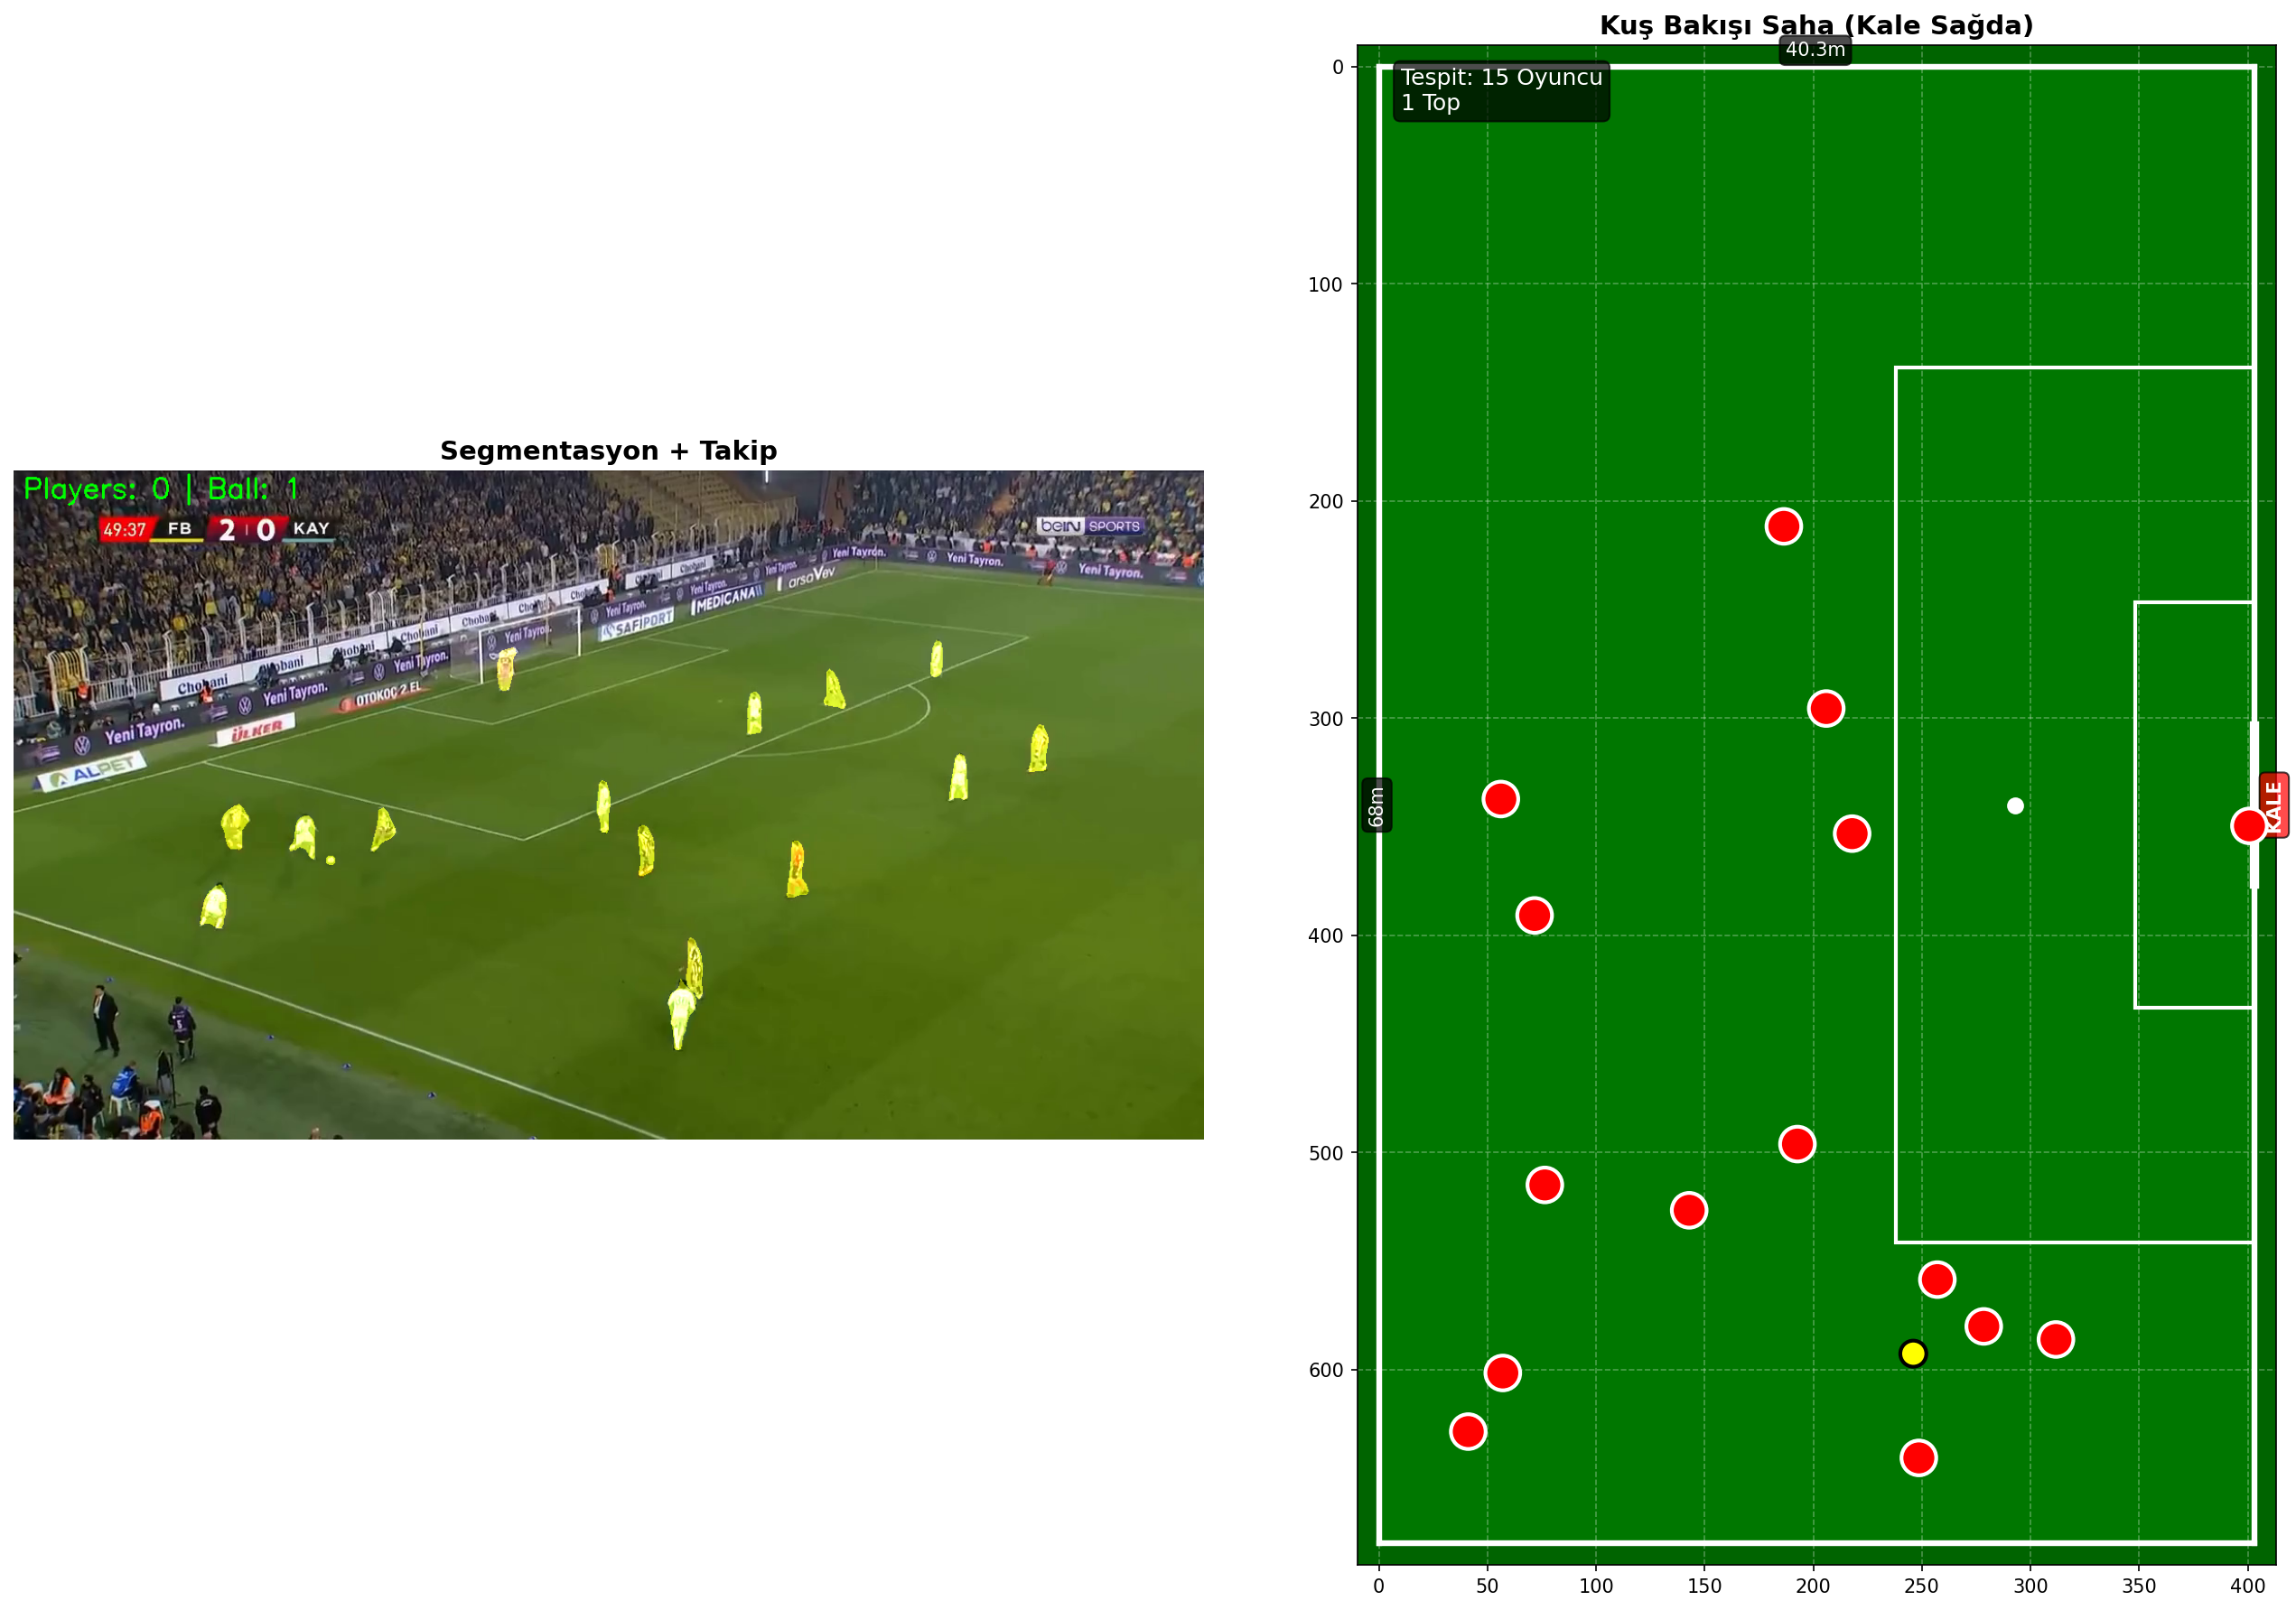


✅ Tek frame görselleştirme tamamlandı!
Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Saha (Kale Sağda)
Saha boyutları: 40.3m x 68m
Penalty area: 16.5m (boy) x 40.3m (en)
Goal area: 5.5m (boy) x 18.7m (en)


In [2]:
import cv2
from ultralytics import YOLO, SAM
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Model ve video yolları
yolo_model_path = "best_futbol.pt"  # Oyuncular için
ball_model_path = "futbol_best.pt"  # Top için
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = "fb2.mp4"

# Modelleri yükle
yolo_model = YOLO(yolo_model_path)
ball_model = YOLO(ball_model_path)
sam_model = SAM(sam_model_path)
print(f"YOLO modeli (oyuncular) yüklendi: {yolo_model_path}")
print(f"YOLO modeli (top) yüklendi: {ball_model_path}")
print(f"MobileSAM modeli yüklendi: {sam_model_path}")

# DeepSORT tracker
tracker_players = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, max_cosine_distance=0.3)

# Videoyu aç ve ilk frame'i al
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    ret, frame = cap.read()
    
    if ret:
        frame_height, frame_width = frame.shape[:2]
        original_frame = frame.copy()
        
        # Perspektif dönüşüm noktaları (kameradan gelen - kale sağ tarafta)
        tl = [1412, 162]
        bl = [712, 712]
        tr = [882, 102]
        br = [-165, 425]
        
        pts_src = np.float32([tl, bl, br, tr])
        # Hedef: 40.3m x 68m (403px x 680px, 1m=10px) - kale sağda (x=403)
        pts_dst = np.float32([[0, 0], [0, 680], [403, 680], [403, 0]])
        matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
        
        # Oyuncular için detection
        player_results = yolo_model(frame, verbose=False)
        ball_results = ball_model(frame, verbose=False)
        
        # Renkler
        np.random.seed(42)
        colors = np.random.randint(0, 255, size=(100, 3), dtype=np.uint8)
        ball_color = (0, 255, 255)
        possession_color = (0, 0, 255)
        
        # Detection listeleri
        player_detections = []
        player_boxes = []
        ball_boxes = []
        player_centers = []
        ball_centers = []
        
        # Oyuncu detections
        if player_results[0].boxes is not None:
            for box in player_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                confidence = float(box.conf[0])
                class_name = yolo_model.names[int(box.cls[0])]
                
                bbox = [x1, y1, x2 - x1, y2 - y1]
                player_detections.append((bbox, confidence, class_name))
                player_boxes.append([x1, y1, x2, y2])
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                player_centers.append((cx, cy))
        
        # Top detections
        ball_position = None
        if ball_results[0].boxes is not None:
            for box in ball_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                ball_boxes.append([x1, y1, x2, y2])
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                ball_centers.append((cx, cy))
                
                if ball_position is None:
                    ball_position = [x1, y1, x2, y2]
        
        # DeepSORT tracking
        player_tracks = tracker_players.update_tracks(player_detections, frame=original_frame)
        
        # Topa en yakın oyuncu
        def calculate_distance(box1, box2):
            center1_x = (box1[0] + box1[2]) / 2
            center1_y = (box1[1] + box1[3]) / 2
            center2_x = (box2[0] + box2[2]) / 2
            center2_y = (box2[1] + box2[3]) / 2
            return np.sqrt((center1_x - center2_x)**2 + (center1_y - center2_y)**2)
        
        closest_player = None
        min_distance = float('inf')
        
        if ball_position is not None:
            for track in player_tracks:
                if track.is_confirmed():
                    ltrb = track.to_ltrb()
                    distance = calculate_distance(ltrb, ball_position)
                    if distance < min_distance and distance < 150:
                        min_distance = distance
                        closest_player = track.track_id
        
        player_with_ball = closest_player
        
        # SAM segmentasyon
        display_frame = original_frame.copy()
        all_boxes = player_boxes + ball_boxes
        
        if len(all_boxes) > 0:
            sam_results = sam_model(original_frame, bboxes=np.array(all_boxes), verbose=False)
            
            if sam_results[0].masks is not None:
                masks = sam_results[0].masks.data.cpu().numpy()
                confirmed_tracks = [t for t in player_tracks if t.is_confirmed()]
                
                for i, mask in enumerate(masks):
                    if i < len(confirmed_tracks):
                        track = confirmed_tracks[i]
                        track_id = track.track_id
                        track_id_int = int(track_id) if isinstance(track_id, str) else track_id
                        
                        if track_id == player_with_ball:
                            color = possession_color
                        else:
                            color = colors[track_id_int % len(colors)]
                        
                        mask = mask.astype(np.uint8) * 255
                        mask_resized = cv2.resize(mask, (frame_width, frame_height))
                        colored_mask = np.zeros_like(display_frame)
                        colored_mask[mask_resized > 0] = color
                        display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
                    
                    elif i >= len(confirmed_tracks):
                        mask = mask.astype(np.uint8) * 255
                        mask_resized = cv2.resize(mask, (frame_width, frame_height))
                        colored_mask = np.zeros_like(display_frame)
                        colored_mask[mask_resized > 0] = ball_color
                        display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
        
        # Topa sahip oyuncu için box çiz
        for track in player_tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = map(int, ltrb)
            
            if track_id == player_with_ball:
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), possession_color, 3)
                label = 'TOPA SAHİP OYUNCU'
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                cv2.rectangle(display_frame, (x1, y1 - text_height - 15), (x1 + text_width + 10, y1), possession_color, -1)
                cv2.putText(display_frame, label, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        # Bilgi metni
        player_count = len([t for t in player_tracks if t.is_confirmed()])
        ball_count = len(ball_boxes)
        info_text = f'Players: {player_count} | Ball: {ball_count}'
        cv2.putText(display_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        if player_with_ball is not None:
            possession_text = f'Topa Sahip Oyuncu ID: {player_with_ball}'
            cv2.putText(display_frame, possession_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Perspektif dönüşümü
        transformed_players = []
        for px, py in player_centers:
            point = np.array([[[px, py]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_players.append((transformed[0][0][0], transformed[0][0][1]))
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Görselleştirme - Yan yana
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Segmentasyon + Takip', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı (40.3m x 68m - kale sağda)
        ax2.set_xlim(-10, 413)
        ax2.set_ylim(690, -10)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Saha (Kale Sağda)', fontsize=14, fontweight='bold')
        
        # Saha çizimi (40.3m uzunluk x 68m genişlik)
        saha = patches.Rectangle((0, 0), 403, 680, linewidth=3, edgecolor='white', facecolor='green', alpha=0.7)
        ax2.add_patch(saha)
        
        # Üst ve alt çizgiler (68m)
        ax2.plot([0, 403], [0, 0], 'white', linewidth=3)
        ax2.plot([0, 403], [680, 680], 'white', linewidth=3)
        
        # Sol çizgi (40.3m çizgisi)
        ax2.plot([0, 0], [0, 680], 'white', linewidth=3)
        
        # Sağ çizgi (kale çizgisi - goal line)
        ax2.plot([403, 403], [0, 680], 'white', linewidth=3)
        
        # Penalty area (16.5m boy x 40.3m en - kale çizgisinden sola)
        penalty_depth = 165  # 16.5m boy
        penalty_width = 403  # 40.3m en
        penalty_x = 403 - penalty_depth
        penalty_y = (680 - penalty_width) / 2
        penalty_area = patches.Rectangle((penalty_x, penalty_y), penalty_depth, penalty_width,
                                        linewidth=2, edgecolor='white', facecolor='none')
        ax2.add_patch(penalty_area)
        
        # Goal area (5.5m boy x 18.7m en)
        goal_depth = 55  # 5.5m boy
        goal_width = 187  # 18.7m en
        goal_x = 403 - goal_depth
        goal_y = (680 - goal_width) / 2
        goal_area = patches.Rectangle((goal_x, goal_y), goal_depth, goal_width,
                                      linewidth=2, edgecolor='white', facecolor='none')
        ax2.add_patch(goal_area)
        
        # Penalty noktası (11m = 110px kale çizgisinden)
        penalty_spot_x = 403 - 110
        penalty_spot_y = 340
        ax2.plot(penalty_spot_x, penalty_spot_y, 'wo', markersize=8)
        
        # Kale (7.32m genişlik, sağ kenarda dikey)
        kale_width = 73
        kale_y = (680 - kale_width) / 2
        ax2.plot([403, 403], [kale_y, kale_y + kale_width], 'white', linewidth=5)
        
        # Oyuncular
        for tx, ty in transformed_players:
            if 0 <= tx <= 403 and 0 <= ty <= 680:
                circle = patches.Circle((tx, ty), 8, color='red', ec='white', linewidth=2, zorder=10)
                ax2.add_patch(circle)
        
        # Top
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 403 and 0 <= tby <= 680:
                circle = patches.Circle((tbx, tby), 6, color='yellow', ec='black', linewidth=2, zorder=11)
                ax2.add_patch(circle)
        
        ax2.grid(True, alpha=0.3, color='white', linestyle='--')
        ax2.set_facecolor('darkgreen')
        
        # Mesafe etiketleri
        ax2.text(201, -5, '40.3m', fontsize=10, color='white', ha='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        ax2.text(-5, 340, '68m', fontsize=10, color='white', rotation=90, va='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        ax2.text(408, 340, 'KALE', fontsize=10, color='white', rotation=90, va='center', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
        
        info_text_bird = f'Tespit: {len(transformed_players)} Oyuncu\n{len(transformed_balls)} Top'
        ax2.text(10, 20, info_text_bird, fontsize=12, color='white',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        
        # Görseli kaydet ve göster
        output_image = 'output_combined_view.png'
        plt.savefig(output_image, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"✅ Görsel kaydedildi: {output_image}")
        
        # Jupyter'da göster
        from IPython.display import Image, display
        display(Image(filename=output_image))
        
        print(f"\n✅ Tek frame görselleştirme tamamlandı!")
        print(f"Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Saha (Kale Sağda)")
        print(f"Saha boyutları: 40.3m x 68m")
        print(f"Penalty area: 16.5m (boy) x 40.3m (en)")
        print(f"Goal area: 5.5m (boy) x 18.7m (en)")
    
    cap.release()


YOLO modeli (oyuncular) yüklendi: best_futbol.pt
YOLO modeli (top) yüklendi: futbol_best.pt
MobileSAM modeli yüklendi: C:\Users\User\Desktop\MobileSAM\mobile_sam.pt


c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ Görsel kaydedildi: output_combined_view.png


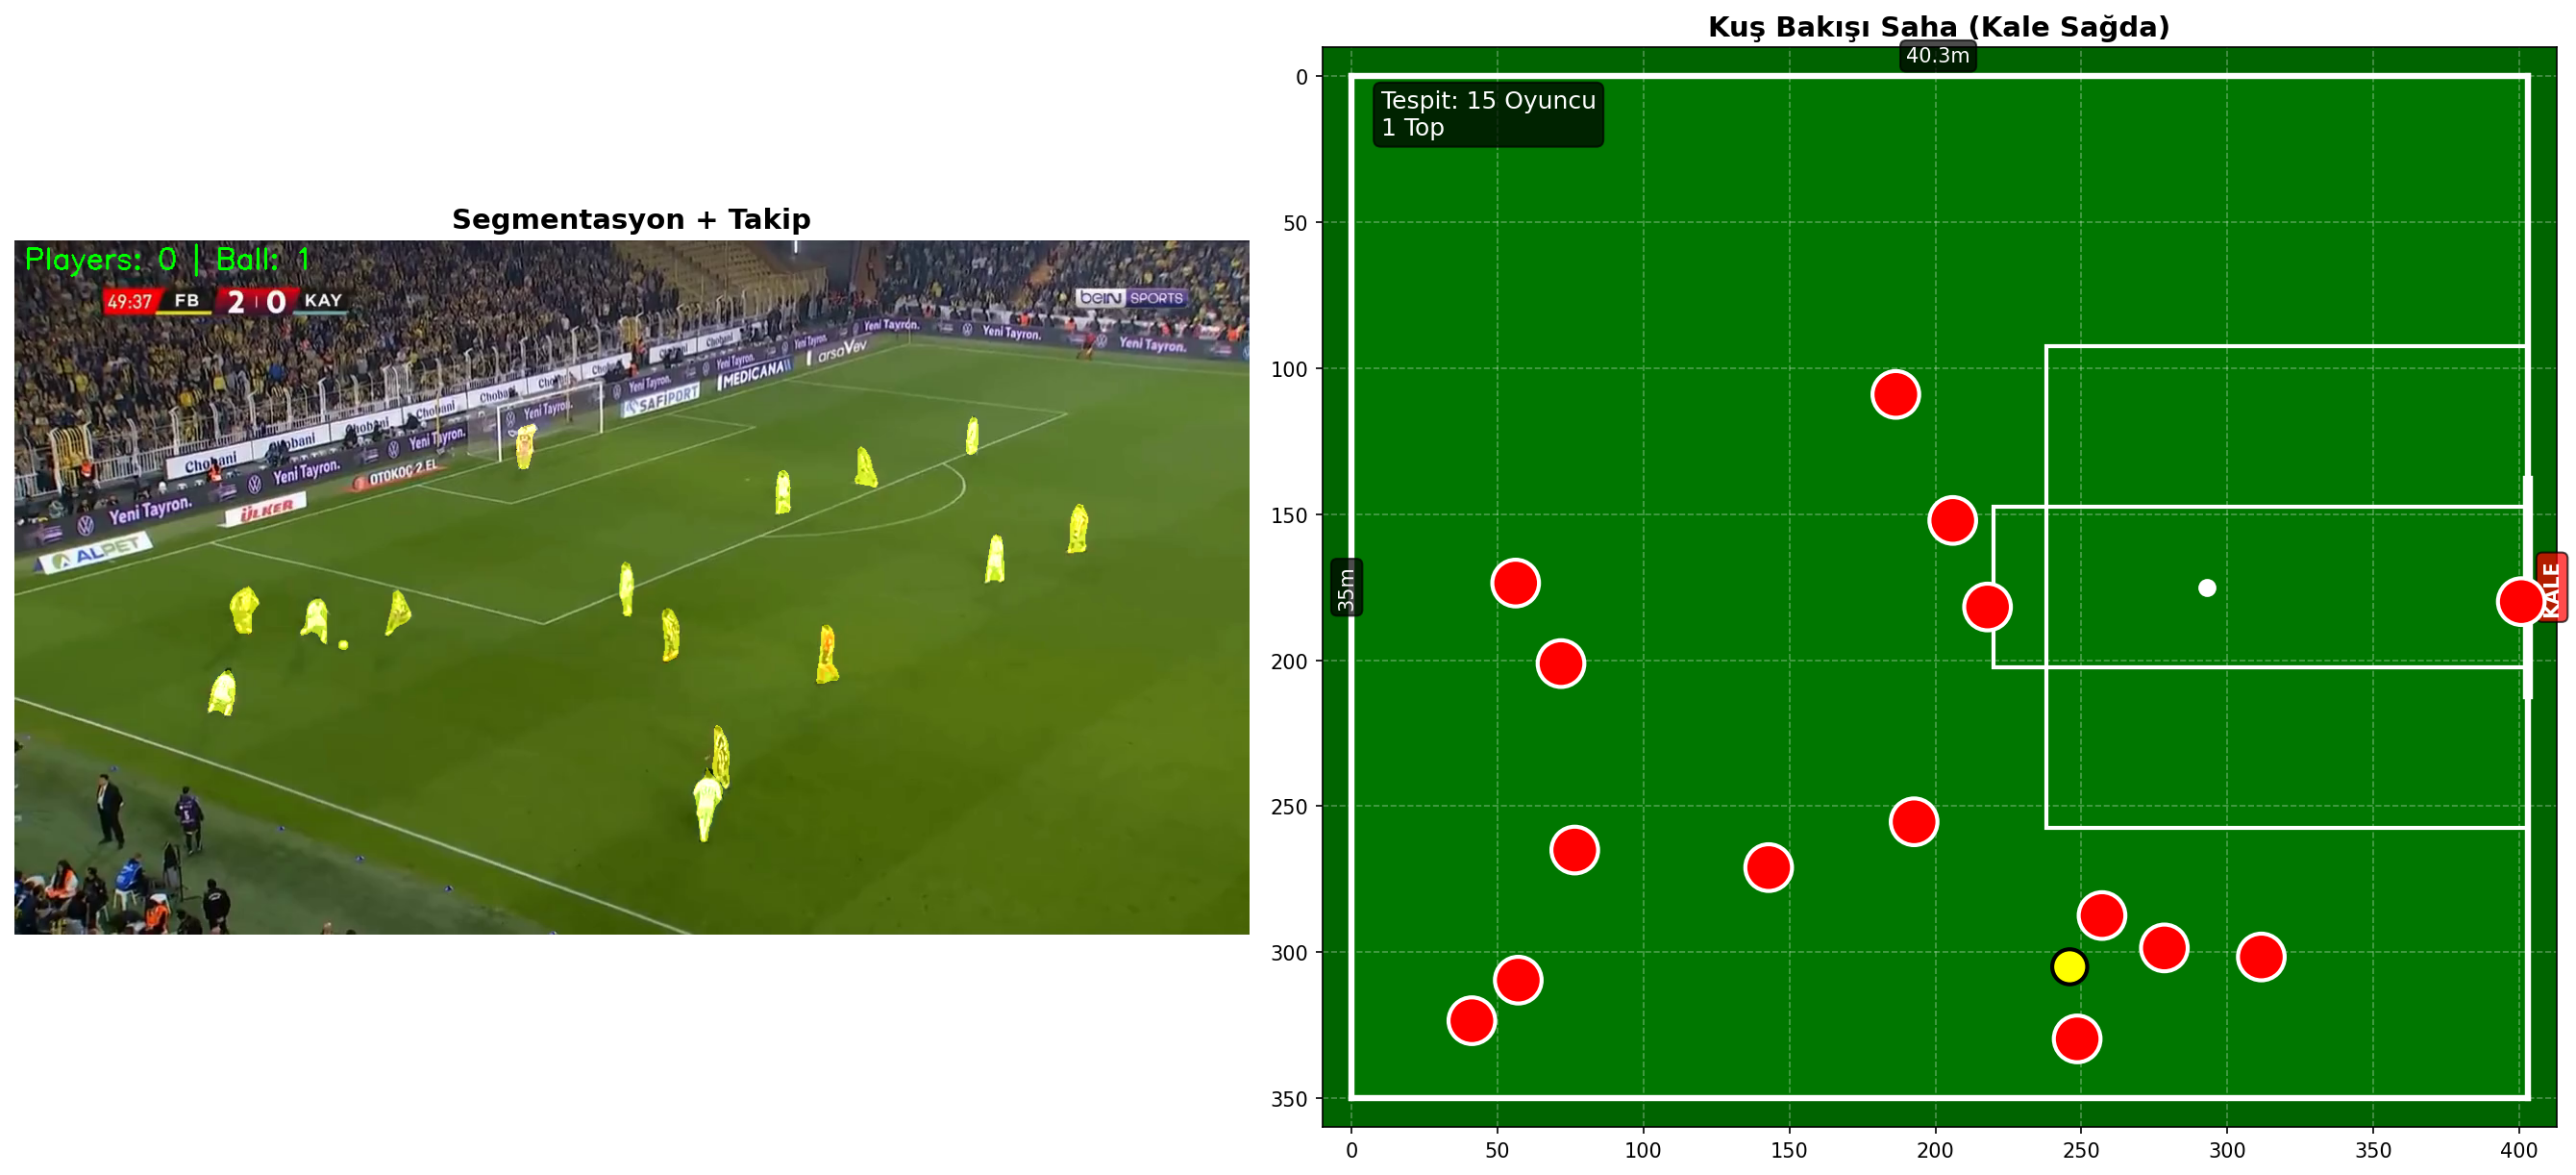


✅ Tek frame görselleştirme tamamlandı!
Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Saha (Kale Sağda)


In [ ]:
import cv2
from ultralytics import YOLO, SAM
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Model ve video yolları
yolo_model_path = "best_futbol.pt"  # Oyuncular için
ball_model_path = "futbol_best.pt"  # Top için
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = "fb2.mp4"

# Modelleri yükle
yolo_model = YOLO(yolo_model_path)
ball_model = YOLO(ball_model_path)
sam_model = SAM(sam_model_path)
print(f"YOLO modeli (oyuncular) yüklendi: {yolo_model_path}")
print(f"YOLO modeli (top) yüklendi: {ball_model_path}")
print(f"MobileSAM modeli yüklendi: {sam_model_path}")

# DeepSORT tracker
tracker_players = DeepSort(max_age=30, n_init=3, nms_max_overlap=1.0, max_cosine_distance=0.3)

# Videoyu aç ve ilk frame'i al
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    ret, frame = cap.read()
    
    if ret:
        frame_height, frame_width = frame.shape[:2]
        original_frame = frame.copy()
        
        # Perspektif dönüşüm noktaları (kameradan gelen - kale sağ tarafta)
        tl = [1412, 162]
        bl = [712, 712]
        tr = [882, 102]
        br = [-165, 425]
        
        pts_src = np.float32([tl, bl, br, tr])
        # Hedef: 40.3m x 35m (403px x 350px) - kale sağda (x=403)
        pts_dst = np.float32([[0, 0], [0, 350], [403, 350], [403, 0]])
        matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
        
        # Oyuncular için detection
        player_results = yolo_model(frame, verbose=False)
        ball_results = ball_model(frame, verbose=False)
        
        # Renkler
        np.random.seed(42)
        colors = np.random.randint(0, 255, size=(100, 3), dtype=np.uint8)
        ball_color = (0, 255, 255)
        possession_color = (0, 0, 255)
        
        # Detection listeleri
        player_detections = []
        player_boxes = []
        ball_boxes = []
        player_centers = []
        ball_centers = []
        
        # Oyuncu detections
        if player_results[0].boxes is not None:
            for box in player_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                confidence = float(box.conf[0])
                class_name = yolo_model.names[int(box.cls[0])]
                
                bbox = [x1, y1, x2 - x1, y2 - y1]
                player_detections.append((bbox, confidence, class_name))
                player_boxes.append([x1, y1, x2, y2])
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                player_centers.append((cx, cy))
        
        # Top detections
        ball_position = None
        if ball_results[0].boxes is not None:
            for box in ball_results[0].boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                ball_boxes.append([x1, y1, x2, y2])
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                ball_centers.append((cx, cy))
                
                if ball_position is None:
                    ball_position = [x1, y1, x2, y2]
        
        # DeepSORT tracking
        player_tracks = tracker_players.update_tracks(player_detections, frame=original_frame)
        
        # Topa en yakın oyuncu
        def calculate_distance(box1, box2):
            center1_x = (box1[0] + box1[2]) / 2
            center1_y = (box1[1] + box1[3]) / 2
            center2_x = (box2[0] + box2[2]) / 2
            center2_y = (box2[1] + box2[3]) / 2
            return np.sqrt((center1_x - center2_x)**2 + (center1_y - center2_y)**2)
        
        closest_player = None
        min_distance = float('inf')
        
        if ball_position is not None:
            for track in player_tracks:
                if track.is_confirmed():
                    ltrb = track.to_ltrb()
                    distance = calculate_distance(ltrb, ball_position)
                    if distance < min_distance and distance < 150:
                        min_distance = distance
                        closest_player = track.track_id
        
        player_with_ball = closest_player
        
        # SAM segmentasyon
        display_frame = original_frame.copy()
        all_boxes = player_boxes + ball_boxes
        
        if len(all_boxes) > 0:
            sam_results = sam_model(original_frame, bboxes=np.array(all_boxes), verbose=False)
            
            if sam_results[0].masks is not None:
                masks = sam_results[0].masks.data.cpu().numpy()
                confirmed_tracks = [t for t in player_tracks if t.is_confirmed()]
                
                for i, mask in enumerate(masks):
                    if i < len(confirmed_tracks):
                        track = confirmed_tracks[i]
                        track_id = track.track_id
                        track_id_int = int(track_id) if isinstance(track_id, str) else track_id
                        
                        if track_id == player_with_ball:
                            color = possession_color
                        else:
                            color = colors[track_id_int % len(colors)]
                        
                        mask = mask.astype(np.uint8) * 255
                        mask_resized = cv2.resize(mask, (frame_width, frame_height))
                        colored_mask = np.zeros_like(display_frame)
                        colored_mask[mask_resized > 0] = color
                        display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
                    
                    elif i >= len(confirmed_tracks):
                        mask = mask.astype(np.uint8) * 255
                        mask_resized = cv2.resize(mask, (frame_width, frame_height))
                        colored_mask = np.zeros_like(display_frame)
                        colored_mask[mask_resized > 0] = ball_color
                        display_frame = cv2.addWeighted(display_frame, 1, colored_mask, 0.5, 0)
        
        # Topa sahip oyuncu için box çiz
        for track in player_tracks:
            if not track.is_confirmed():
                continue
            
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = map(int, ltrb)
            
            if track_id == player_with_ball:
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), possession_color, 3)
                label = 'TOPA SAHİP OYUNCU'
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                cv2.rectangle(display_frame, (x1, y1 - text_height - 15), (x1 + text_width + 10, y1), possession_color, -1)
                cv2.putText(display_frame, label, (x1 + 5, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        # Bilgi metni
        player_count = len([t for t in player_tracks if t.is_confirmed()])
        ball_count = len(ball_boxes)
        info_text = f'Players: {player_count} | Ball: {ball_count}'
        cv2.putText(display_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        if player_with_ball is not None:
            possession_text = f'Topa Sahip Oyuncu ID: {player_with_ball}'
            cv2.putText(display_frame, possession_text, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Perspektif dönüşümü
        transformed_players = []
        for px, py in player_centers:
            point = np.array([[[px, py]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_players.append((transformed[0][0][0], transformed[0][0][1]))
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Görselleştirme - Yan yana
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Segmentasyon + Takip', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı (40.3m x 35m - kale sağda)
        ax2.set_xlim(-10, 413)
        ax2.set_ylim(360, -10)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Saha (Kale Sağda)', fontsize=14, fontweight='bold')
        
        # Saha çizimi (40.3m uzunluk x 35m genişlik)
        saha = patches.Rectangle((0, 0), 403, 350, linewidth=3, edgecolor='white', facecolor='green', alpha=0.7)
        ax2.add_patch(saha)
        
        # Üst ve alt çizgiler (35m)
        ax2.plot([0, 403], [0, 0], 'white', linewidth=3)
        ax2.plot([0, 403], [350, 350], 'white', linewidth=3)
        
        # Sol çizgi (40.3m çizgisi)
        ax2.plot([0, 0], [0, 350], 'white', linewidth=3)
        
        # Sağ çizgi (kale çizgisi - goal line)
        ax2.plot([403, 403], [0, 350], 'white', linewidth=3)
        
        # Penalty area (16.5m x 16.5m - kale çizgisinden sola)
        penalty_width = 165
        penalty_depth = 165
        penalty_x = 403 - penalty_depth
        penalty_y = (350 - penalty_width) / 2
        penalty_area = patches.Rectangle((penalty_x, penalty_y), penalty_depth, penalty_width,
                                        linewidth=2, edgecolor='white', facecolor='none')
        ax2.add_patch(penalty_area)
        
        # Goal area (5.5m x 18.32m)
        goal_width = 183
        goal_depth = 55
        goal_x = 403 - goal_depth
        goal_y = (350 - goal_width) / 2
        goal_area = patches.Rectangle((goal_x, goal_y), goal_depth, goal_width,
                                      linewidth=2, edgecolor='white', facecolor='none')
        ax2.add_patch(goal_area)
        
        # Penalty noktası (11m = 110px kale çizgisinden)
        penalty_spot_x = 403 - 110
        penalty_spot_y = 175
        ax2.plot(penalty_spot_x, penalty_spot_y, 'wo', markersize=8)
        
        # Kale (7.32m genişlik, sağ kenarda dikey)
        kale_width = 73
        kale_y = (350 - kale_width) / 2
        ax2.plot([403, 403], [kale_y, kale_y + kale_width], 'white', linewidth=5)
        
        # Oyuncular
        for tx, ty in transformed_players:
            if 0 <= tx <= 403 and 0 <= ty <= 350:
                circle = patches.Circle((tx, ty), 8, color='red', ec='white', linewidth=2, zorder=10)
                ax2.add_patch(circle)
        
        # Top
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 403 and 0 <= tby <= 350:
                circle = patches.Circle((tbx, tby), 6, color='yellow', ec='black', linewidth=2, zorder=11)
                ax2.add_patch(circle)
        
        ax2.grid(True, alpha=0.3, color='white', linestyle='--')
        ax2.set_facecolor('darkgreen')
        
        # Mesafe etiketleri
        ax2.text(201, -5, '40.3m', fontsize=10, color='white', ha='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        ax2.text(-5, 175, '35m', fontsize=10, color='white', rotation=90, va='center',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        ax2.text(408, 175, 'KALE', fontsize=10, color='white', rotation=90, va='center', fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
        
        info_text_bird = f'Tespit: {len(transformed_players)} Oyuncu\n{len(transformed_balls)} Top'
        ax2.text(10, 20, info_text_bird, fontsize=12, color='white',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        
        # Görseli kaydet ve göster
        output_image = 'output_combined_view.png'
        plt.savefig(output_image, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"✅ Görsel kaydedildi: {output_image}")
        
        # Jupyter'da göster
        from IPython.display import Image, display
        display(Image(filename=output_image))
        
        print(f"\n✅ Tek frame görselleştirme tamamlandı!")
        print(f"Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Saha (Kale Sağda)")
    
    cap.release()


xcvxcv
